# Labraries and functions

## Load labraries

In [1]:
import os
import numpy as np
import pandas as pd
import time
import fatpack
import rainflow
from scipy.signal import butter, filtfilt, detrend
#import torch
#from torch.utils.data import Dataset, DataLoader
#import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard


from tensorflow.keras.layers import Add, BatchNormalization, Input, Conv1D, Activation, MaxPooling1D, Flatten, Dense, Dropout, MultiHeadAttention,Layer,LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.layers import ZeroPadding1D


from keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, Activation, Flatten
from keras import backend as K
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Activation, Dropout, concatenate, BatchNormalization
from keras.regularizers import l2

from keras.models import Model



# filter the warnings
import warnings
warnings.filterwarnings("ignore")


import random
# Seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seed(42)

In [2]:
# use gpu for tf
physical_devices = tf.config.list_physical_devices('GPU')
# check if the GPU is used
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Define functions

In [3]:
def calculate_receptive_field(kernels, strides, pools):
    """
    Calculate the receptive field for a series of convolutional and pooling layers.

    Parameters:
    - kernels (list of int): List of kernel sizes for each convolutional layer.
    - strides (list of int): List of stride values for each convolutional layer.
    - pools (list of int): List of pool sizes for each pooling layer (assumed to follow each conv layer).

    Returns:
    - int: The receptive field of the network.
    """
    receptive_field = 1
    jump = 1
    
    for kernel, stride, pool in zip(kernels, strides, pools):
        receptive_field += (kernel - 1) * jump
        jump *= stride
        receptive_field += (pool - 1) * jump
        jump *= pool
    
    return receptive_field

# Function to round values to the nearest interval of 0.5
def round_to_nearest_half(values):
    return np.round(values * 2) / 2


def custom_loss(y_true, y_pred):
    """
    Custom loss function that applies a different penalty if the prediction is less than the actual value.
    If the prediction is smaller, the loss is 2 times the usual mean squared error.
    Otherwise, the loss is the normal mean squared error.
    """
    # Calculate the squared difference
    squared_difference = tf.square(y_true - y_pred)
    
    # Check where predictions are smaller than true values
    under_prediction = tf.cast(y_pred < y_true, dtype=tf.float32)
    
    # Apply double weight to under-predictions
    weighted_squared_difference = squared_difference * (1 + under_prediction)
    
    # Return mean of weighted squared difference
    return tf.reduce_mean(weighted_squared_difference, axis=-1)


# Cyclical Learning Rate (CLR) Scheduler
class CyclicLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr, max_lr, step_size, mode='triangular'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.clr_iterations = 0
        self.trn_iterations = 0
        self.history = {}

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.mode == 'triangular':
            lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x))
        return lr

    def on_train_begin(self, logs=None):
        logs = logs or {}
        if self.clr_iterations == 0:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())




def weighted_mse_exponential(y_true, y_pred):
    # Define exponential weights - ensure this matches your output size
    # Convert the base and exponent range to float32 explicitly
    
    base_weight = 1.2  # Use float to ensure type compatibility

    exponent_range = K.cast(K.arange(1, 17), 'float32')  # Explicitly cast to float32
    weights = K.pow(base_weight, exponent_range)  # Now both base and exponent are float32
    weights = K.reshape(weights, (1, 16))  # Reshape to match y_pred shape
    # normalize the weights
    weights = weights / K.sum(weights)
    
    # Calculate MSE
    error = y_true - y_pred
    squared_error = K.square(error)
    weighted_squared_error = squared_error * weights  # Apply weights
    return K.mean(weighted_squared_error, axis=-1)


def weighted_mse_exponential_modified(y_true, y_pred):
    # Define exponential weights for the first 18
    base_weight = 1.6  # Use float to ensure type compatibility
    
    # First 18 weights increasing
    exponent_range_increasing = K.cast(K.arange(1, 13), 'float32')  # Exponents for the increasing part
    increasing_weights = K.pow(base_weight, exponent_range_increasing)  # Increasing weights
    
    # Last 6 weights decreasing - Option 1: Direct computation of decreasing weights
    exponent_range_decreasing = K.cast(K.arange(1, 13), 'float32')  # Exponents for the decreasing part, could be adjusted
    decreasing_weights = K.pow(base_weight, -exponent_range_decreasing)  # Make these weights decrease
    decreasing_weights = decreasing_weights * K.pow(base_weight, 12)  # Adjust to make sure they start from where increasing part left off
    
    # Concatenate the increasing and decreasing weights
    weights = K.concatenate([increasing_weights, decreasing_weights], axis=0)
    # Normalize the weights
    weights = weights / K.sum(weights)
    weights = K.reshape(weights, (1, 24))  # Reshape to match y_pred shape

    # Calculate MSE
    error = y_true - y_pred
    squared_error = K.square(error)
    weighted_squared_error = squared_error * weights  # Apply weights
    return K.mean(weighted_squared_error, axis=-1)




def weighted_mse_exponential_normal_distribution(y_true, y_pred):
    # Parameters for the normal distribution
    mu = 10.0  # Mean of the distribution, centered at 12 for a 24-length sequence
    sigma = 3.0  # Standard deviation of the distribution
    
    # Generate indices for the weights
    x_values = tf.range(1, 21, dtype=tf.float32)
    
    # Calculate the normal distribution weights using TensorFlow operations
    weights = tf.exp(-((x_values - mu) ** 2) / (2 * sigma ** 2))
    
    # Normalize weights to ensure they sum to 1 (optional based on your requirement)
    weights /= tf.reduce_sum(weights)
    
    # Reshape weights to match y_pred shape
    weights = tf.reshape(weights, (1, 21))
    

    # Calculate weighted MSE using TensorFlow operations
    error = y_true - y_pred
    squared_error = tf.square(error)
    weighted_squared_error = squared_error * weights  # Apply weights
    return tf.reduce_mean(weighted_squared_error, axis=-1)


def weighted_mse_log_normal_distribution(y_true, y_pred):
    # Parameters for the log-normal distribution
    mu = 2.7  # Adjusted for the scale of indices, typically log of the mean of x-values
    sigma = 0.6  # Adjusted variance

    # Generate indices for the weights
    x_values = tf.range(1, 21, dtype=tf.float32)
    
    # Calculate the log-normal distribution weights using TensorFlow operations
    # Adjusting x_values to be in the domain > 0 and applying log-normal PDF formula
    weights = (1 / (x_values * sigma * tf.sqrt(2 * np.pi))) * tf.exp(-((tf.math.log(x_values) - mu) ** 2) / (2 * sigma ** 2))
    
    # Normalize weights to ensure they sum to 1 (optional based on your requirement)
    weights /= tf.reduce_sum(weights)
    
    # Reshape weights to match y_pred shape
    weights = tf.reshape(weights, (1, 21))
    
    # Calculate weighted MSE using TensorFlow operations
    error = y_true - y_pred
    squared_error = tf.square(error)
    weighted_squared_error = squared_error * weights  # Apply weights
    return tf.reduce_mean(weighted_squared_error, axis=-1)




def create_dataset(X, y, window_size,pred_num = 1):
    """"
    This function creates the dataset with the window size for lstm
    The input data might be the train_x or test_x or test_y or train_y
    The window size is the number of data points in each

    x: the input data
    y: the output data
    window_size: the number of data points in each window
    pred_num: the number of data points

    """

    Xs, ys = [], []
    for i in range(len(X) - window_size):
        v = X.iloc[i:(i + window_size)]
        Xs.append(v)
        ys.append(y.iloc[i +window_size +1-pred_num:i +window_size + 1])
    return np.array(Xs), np.array(ys) 




def plot_fft(signal, title, plot = 0, eli = 15):
    """
    This function plots the FFT of a signal.

    signal: the signal to plot the FFT of  
    title: the title of the plot
    plot: the number of points to plot
    eli: the number of points to eliminate from frequency domain
    """     
                    
    # Compute the FFT
    fft_vals = np.fft.fft(signal)
    fft_vals = np.abs(fft_vals)/len(signal)   # normalized values
    fft_vals[:eli] = 0             # eliminate the influence of first component


    # Compute the frequencies associated with the FFT values
    # The frequency is set as 150Hz
    fft_freq = np.fft.fftfreq(len(signal),1/200)

    # Plot the FFT values vs frequencies
    plt.figure(figsize=(10, 5))
    if plot != 0:
      plt.plot(np.abs(fft_freq)[:plot], fft_vals[:plot])
    else:
      plt.plot(np.abs(fft_freq), fft_vals)
    plt.title(f'FFT of {title}')
    plt.xlabel('Frequency')
    plt.ylabel('FFT Value')
    plt.grid(True)
    plt.show()



def butter_lowpass(signal, cutoff, fs, order=5, btype='low'):
    """
    Attenuate the signal with a low-pass Butterworth

    Parameters:
    - signal: The input signal (1D numpy array).
    - cutoff: Cut-off frequency (Hz)
    - btpe: The type of filter. 'low' for low-pass filter.
    - order: The order of the filter.
    - fs: The sampling frequency of the signal (Hz).

    Returns:
    - filtered_signal: The filtered signal (1D numpy array).
    """
    # Nyquist frequency
    nyquist = 0.5 * fs
    # Normalize the frequency
    normal_cutoff = cutoff / nyquist
    
    # Design the Butterworth filter
    b, a = butter(order, normal_cutoff, btype=btype)
    # Apply the filter
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal




def zero_out_frequency_range_fft(signal, lowcut, highcut, fs = 200):
    """
    Zero out a specific frequency range in a signal using FFT.

    Parameters:
    - signal: The input signal (1D numpy array).
    - lowcut: The lower frequency bound to zero out (Hz).
    - highcut: The upper frequency bound to zero out (Hz).
    - fs: The sampling frequency of the signal (Hz).

    Returns:
    - signal_filtered: The signal with the specified frequency range zeroed out.
    """
    # Perform FFT
    signal_fft = np.fft.fft(signal)
    # Get the frequency bins
    freq = np.fft.fftfreq(len(signal), 1/fs)
    
    # Zero out the desired frequency range
    # Use np.logical_and to find the indices where the frequency range falls
    mask = np.logical_or(freq < highcut, freq > lowcut)
    mask = np.logical_or(mask, freq > -lowcut)
    mask = np.logical_or(mask, freq < -highcut)
    signal_fft[mask] = 0

    # Perform inverse FFT
    signal_filtered = np.fft.ifft(signal_fft)

    # Since the imaginary part is due to numerical error, we take only the real part
    return np.real(signal_filtered)


def find_time_delay(signal1, signal1_name, signal2, signal2_name, fs, sensor_data = True, save_plot=False):
    """
    Find the time delay between two signals based on cross-correlation.
    
    :param signal1: The first signal (array-like).
    :param signal2: The second signal (array-like).
    :param fs: Sampling frequency of the signals.
    :return: Time delay in seconds.
    """
    # Compute cross-correlation
    correlation = np.correlate(signal1, signal2, mode='full')
    
    # Find the lag corresponding to the maximum correlation
    lag_idx = np.argmax(correlation) - (len(signal2) - 1)
    
    # Convert lag to time in seconds
    time_delay = lag_idx / fs
    
    # Visualize the cross-correlation process
    lags = np.arange(-len(signal2) + 1, len(signal1))
    time_lags = lags / fs
    plt.figure(figsize=(12, 6))
    plt.plot(time_lags, correlation)
    if sensor_data:
        title = 'Cross-Correlation of signal '+signal1_name+' and '+signal2_name +' (sensor)'
    else:
        title = 'Cross-Correlation of signal '+signal1_name+' and '+signal2_name +' (FEM data)' 
    plt.title(title)
    plt.xlabel('Time Lag (s)')
    plt.ylabel('Cross-Correlation Amplitude')
    plt.axvline(time_delay, color='r', linestyle='--', label=f'Time Delay: {time_delay}s')
    plt.legend()
    plt.grid(True)
    if save_plot:
        plt.savefig(title+'.svg', dpi=1000)
    
    plt.show()
    
    return time_delay


In [4]:
def decompose_signal(signal, num_components=10):
    # Compute the FFT of the signal
    spectrum = np.fft.fft(signal)
    
    # Get the length of the signal
    N = len(signal)
    
    # Determine the size of each section
    section_size = N // num_components
    
    # List to store the components
    components = []
    
    for i in range(num_components):
        # Copy the spectrum to zero out other frequencies
        temp_spectrum = np.zeros_like(spectrum)
        
        # Determine the start and end indices for this section
        start_idx = i * section_size
        end_idx = (i + 1) * section_size
        
        # Retain only the frequencies in this section
        temp_spectrum[start_idx:end_idx] = spectrum[start_idx:end_idx]
        
        # Compute the inverse FFT to get the component
        component = np.fft.ifft(temp_spectrum)
        
        components.append(component)
    
    return components



# define a function to plot the components
def plot_components(components, title=None):
    # Get the number of components
    num_components = len(components)
     
    plt.figure(figsize=(14, 6))
    #plt.plot(np.arange(num_components), signal, label="Original Signal", color="black", linewidth=2)
    for i, component in enumerate(components):
        plt.plot(component, label=f"Component {i}")
    
        plt.legend()
        plt.title("Original Signal and its Components")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)
    plt.title(title)
    # Display the plot
    plt.show()

# def a function to save the decompose_signal() to the dataframe with name 'ACC1_component_0', 'ACC1_component_1', ...
# only save the real part of the components
def save_components(data, column_name, num_components=10):
    components = decompose_signal(data[column_name], num_components=num_components)
    for i, component in enumerate(components):
        data[f"{column_name}_component_{i}"] = component.real
    return data


def extract_max_magnitude_component(signal, sampling_rate, freq_range):
    # Perform FFT on the signal
    signal_fft = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1/sampling_rate)

    # Consider only positive frequencies
    positive_mask = frequencies > 0
    signal_fft = signal_fft[positive_mask]
    frequencies = frequencies[positive_mask]

    # Plot the magnitude of the FFT (for visualization)
    plt.figure()
    plt.plot(frequencies, np.abs(signal_fft))
    plt.title('Magnitude of FFT')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)

    # Identify the frequency component with the highest magnitude within the specified frequency range
    range_mask = (frequencies >= freq_range[0]) & (frequencies <= freq_range[1])
    max_magnitude_freq = frequencies[range_mask][np.argmax(np.abs(signal_fft[range_mask]))]

    # Zero out all components except the frequency with the highest magnitude in the given range
    full_signal_fft = np.fft.fft(signal)
    full_signal_fft[np.abs(np.fft.fftfreq(len(signal), 1/sampling_rate)) != max_magnitude_freq] = 0

    # Perform inverse FFT to get the time-domain signal of the target frequency
    extracted_signal = np.fft.ifft(full_signal_fft).real

    # Plot the extracted signal (for visualization)
    plt.figure()
    plt.plot(extracted_signal)
    plt.title(f'Extracted Signal at {max_magnitude_freq:.2f} Hz')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.show()

    return extracted_signal


    # define a funtion to reconstrute the singal from each component with the same prefix in the dataframe
def reconstruct_signal(data, column_prefix):
    # Get the columns with the given prefix
    component_columns = [col for col in data.columns if col.startswith(column_prefix)]
    
    # Get the number of components
    num_components = len(component_columns)
    
    # Initialize the reconstructed signal to be all zeros
    reconstructed_signal = np.zeros_like(data[component_columns[0]])
    
    # Iterate through the components and add them up
    for i in range(num_components):
        reconstructed_signal += data[component_columns[i]]
    
    return reconstructed_signal

# Data preparation 

In [5]:
# The bridge has six spans, and total length is 188.6m. The train's length is 107m. The train is moving from left to right.
# The highes speed of the train is 120km/h, which is 120/3.6 = 33.33m/s
# the time for the train to pass the bridge is (188.6+107)/33.33 = 8.6s
# The sampling rate is 400Hz, so the number of data points for the train to pass the bridge is 400*8.6 = 3440


# the lowest speed of the train is 70km/h, which is 70/3.6 = 19.44m/s
# the time for the train to pass the bridge is (188.6+107)/19.44 = 14.7s
# The sampling rate is 400Hz, so the number of data points for the train to pass the bridge is 400*14.7 = 5880

## Load the data

In [5]:


#Specify the folder where the .mat files are located
#folderPath = "training_data_200_samples"
folderPath = "New_training_data_200_samples"


#Get a list of all .csv files in the specified folder

fileList = os.listdir(folderPath)
fileList = [f for f in fileList if f.endswith('.csv')]
print(len(fileList))

# Load the data from the all the .csv files into a dataframe and store the dataframe in a dictionary with the file name as the key
data_dict = {}
for file in fileList:
    data_dict[file] = pd.read_csv(os.path.join(folderPath, file)).astype('float32')

# Print the first few rows of the first file
data_dict[fileList[0]].head()

200


Time       SG5       SG7      SG13      SG16      SG33      SG35  \
0  530.002502  0.139024  0.339830  0.218572  0.167403  0.453162  0.304645   
1  530.005005  0.152549  0.351664  0.203355  0.162331  0.458234  0.289428   
2  530.007507  0.047719  0.253598  0.128959  0.072718  0.365238  0.199815   
3  530.010010 -0.109528  0.123403  0.005529 -0.054094  0.186012  0.035804   
4  530.012512 -0.231267  0.013500 -0.122974 -0.162307  0.028765 -0.118061   

       SG42      SG43        A1  ...  SG13Range  SG13Cycles  SG16Range  \
0  0.260039  0.250971  8.365758  ...        2.0       856.5        2.0   
1  0.227915  0.278025  8.365686  ...        4.0         0.0        4.0   
2  0.143375  0.237445  8.364429  ...        6.0         0.0        6.0   
3  0.014871  0.114014  8.363058  ...        8.0         0.0        8.0   
4 -0.103488 -0.011106  8.362710  ...       10.0         0.0       10.0   

   SG16Cycles  SG42Range  SG42Cycles  SG43Range  SG43Cycles  velocity_16  \
0       874.5        2.0       859.5        2.0       863.0    88.247551   
1         2.0        4.0         2.0        4.0         1.0    88.247551   
2         0.0        6.0         0.0        6.0         0.0    88.247551   
3         0.0        8.0         0.0        8.0         0.0    88.247551   
4         2.0       10.0         3.0       10.0         0.0    88.247551   

   velocity_5+7  
0      73.30909  
1      73.30909  
2      73.30909  
3      73.30909  
4      73.30909  

[5 rows x 23 columns]

In [ ]:
"""imcomplete_data = [30,31,45,59,63,82,84,111,119,131,140,144,145,165,190,195,225,253]
imcomplete_file_name = []
for i in imcomplete_data:
    imcomplete_file_name.append(fileList[i])

#delete the imcomplete data from the data_dict
for file in imcomplete_file_name:
    del data_dict[file]
# delete the imcomplete data from the fileList
fileList = [f for f in fileList if f not in imcomplete_file_name]
#check the size of the data_dict
len(data_dict)"""

In [6]:
acc_only = False

# For each dataframe in the dictionary, save the components of the acc_2 and acc_4 signals to the dataframe
for file in fileList:
    if acc_only:
        # drop the columns acc_1, acc_3, strain_2, WIM_1 and WIM_2
        data_dict[file] = data_dict[file].drop(columns=['A1', 'A3', 'SG13', 'SG16', 'SG42','SG43'])
        # offset correction for acc_2
        data_dict[file]['A2'] = data_dict[file]['A2'] - data_dict[file]['A2'][:500].mean()
        # put the strain_1 to the first column
        #data_dict[file] = data_dict[file][['strain_1', 'acc_2','offset_stress_1','Range','Cycles','velocity']]
        #data_dict[file] = save_components(data_dict[file], 'acc_2', num_components = num_component)
    else:
        # drop the columns acc_1, acc_3, strain_2, WIM_1 and WIM_2
        data_dict[file] = data_dict[file].drop(columns=[ 'Time'])
        #data_dict[file] = data_dict[file].drop(columns=[ 'Time','SG13', 'SG16', 'SG42','SG43'])
        # offset correction for acc_2
        data_dict[file]['A1'] = data_dict[file]['A1'] - data_dict[file]['A1'][:500].mean()
        data_dict[file]['A2'] = data_dict[file]['A2'] - data_dict[file]['A2'][:500].mean()
        data_dict[file]['A4'] = data_dict[file]['A4'] - data_dict[file]['A4'][:500].mean()
        data_dict[file]['A5'] = data_dict[file]['A5'] - data_dict[file]['A5'][:500].mean()
        # put the strain_1 to the first column
        #data_dict[file] = data_dict[file][['strain_1', 'acc_2', 'acc_1','acc_3','acc_4','offset_stress_1','Range','Cycles','velocity']]
        #data[file] = save_components(data[file], 'acc_2', num_components = num_component)
        #data[file] = save_components(data[file], 'acc_1', num_components = num_component)

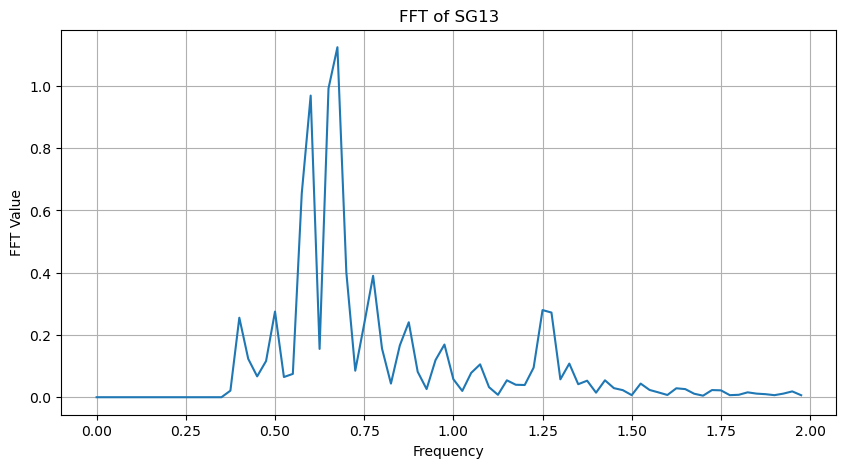

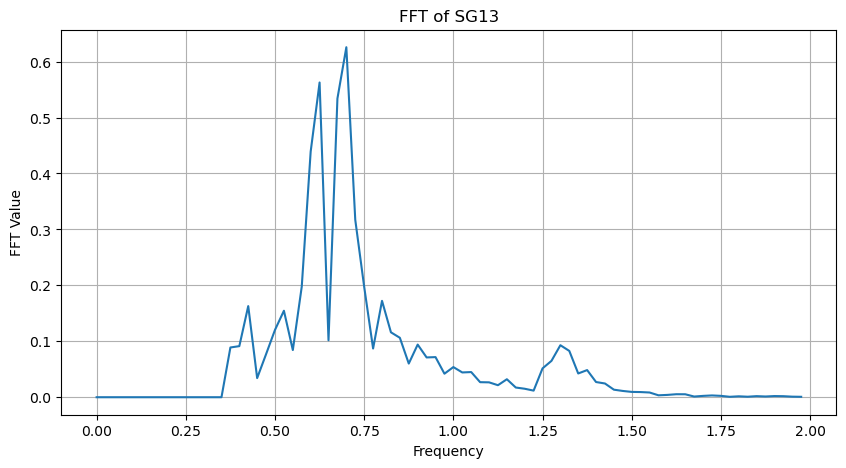

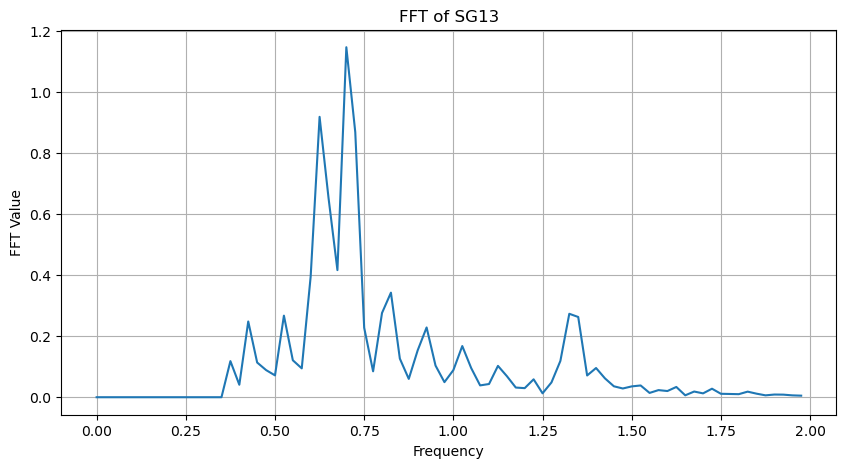

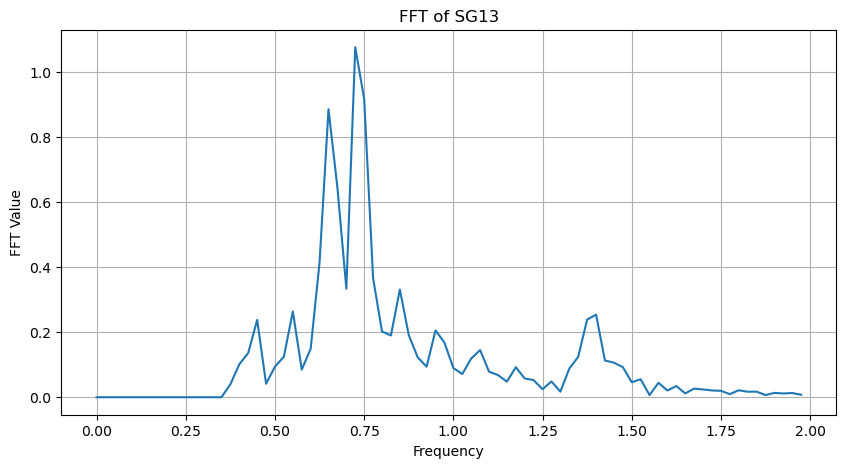

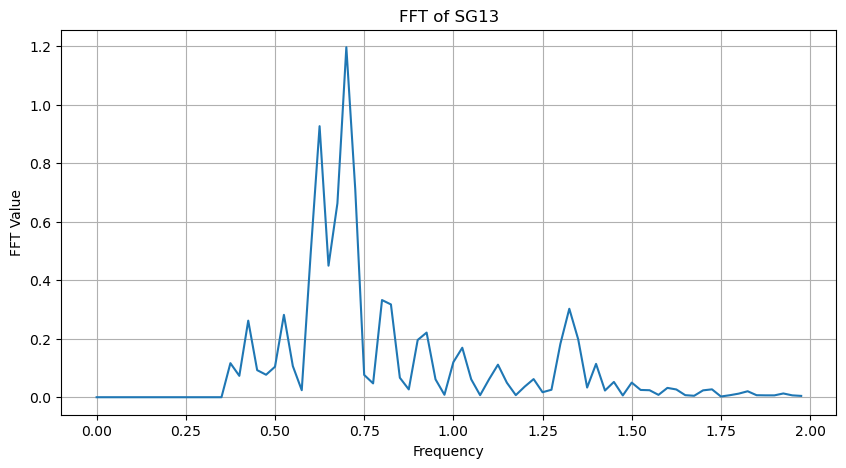

In [7]:
# plot the fft of the signal SG13	
plot_fft(data_dict[fileList[0]]['SG13'], title="SG13", eli = 15,plot= 80)
plot_fft(data_dict[fileList[1]]['SG13'], title="SG13", eli = 15,plot= 80)
plot_fft(data_dict[fileList[2]]['SG13'], title="SG13", eli = 15,plot= 80)
plot_fft(data_dict[fileList[3]]['SG13'], title="SG13", eli = 15,plot= 80)
plot_fft(data_dict[fileList[4]]['SG13'], title="SG13", eli = 15,plot= 80)

# Define a function to plot the FFT of a signal
#def plot_fft(signal, title, plot = 0, eli = 15):

In [ ]:
"""the natural frequency of the bridge is 1.4Hz, the sampling rate is 400Hz, so the recptive field should be around 400/1.4 = 285.7"""

#### check sensors' errors

Text(0.5, 1.0, 'SG42---bottom strain gauge')

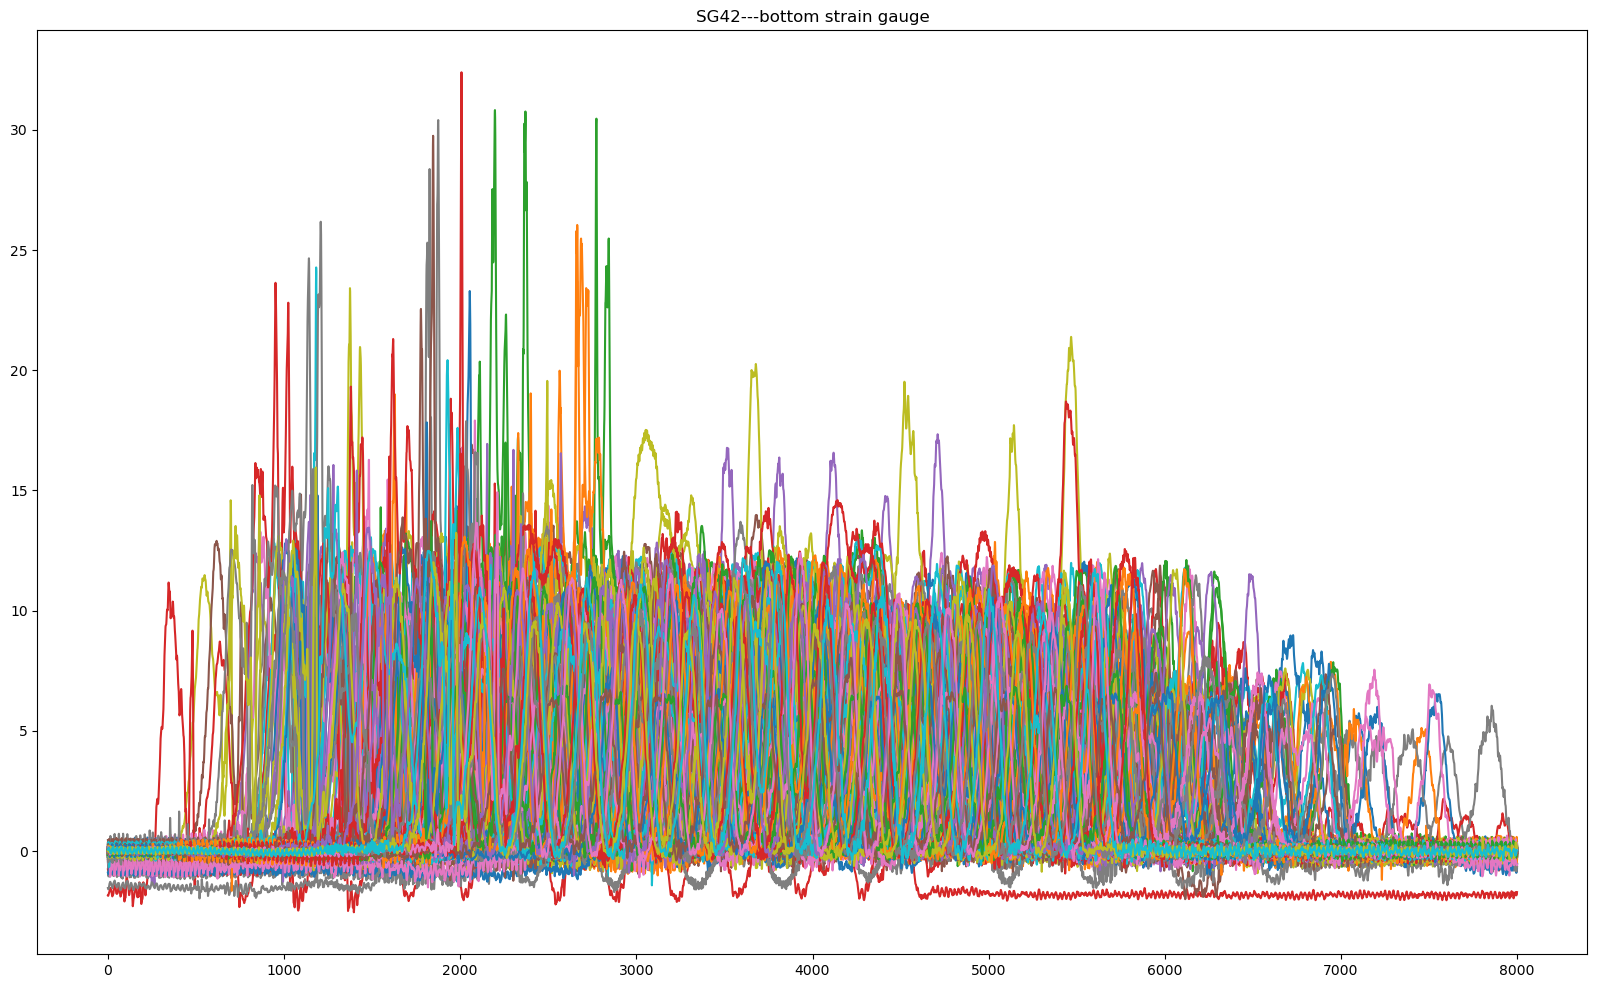

In [7]:
plt.figure(figsize=(20,12))
for i in fileList:
    plt.plot(data_dict[i]['SG42'], label= i)
plt.title('SG42---bottom strain gauge')


In [ ]:
plt.figure(figsize=(20,12))
for i in fileList:
    plt.plot(data_dict[i]['SG16'], label= i)
    plt.title('SG16---bottom strain gauge')



In [ ]:
plt.figure(figsize=(20,12))
for i in fileList:
    plt.plot(data_dict[i]['SG13'], label= i)
plt.title('SG13---top strain gauge')

In [ ]:
plt.figure(figsize=(20,12))
for i in fileList:
    plt.plot(data_dict[i]['SG43'], label= i)
plt.title('SG43---top strain gauge')

## SG16 vs SG42

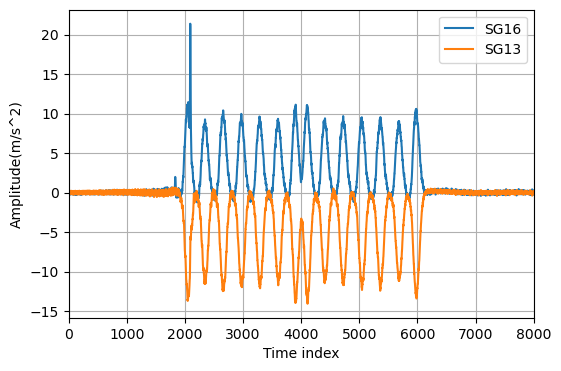

In [19]:

plt.figure(figsize=(6, 4))
plt.plot(data_dict[fileList[0]]['SG16'],label='SG16')
plt.plot(data_dict[fileList[0]]['SG13'],label='SG13')
    #plt.plot(data_dict[fileList[i]]['A4'],label='A4')
    #plt.plot(data_dict[fileList[i]]['A5'],label='A5')
plt.xlabel("Time index")
plt.ylabel("Amplitude(m/s^2)")
plt.legend()
plt.grid(True)
# limit x-axis to 0-8000
plt.xlim(0, 8000)
#plt.title(f'Index {i}')
# save the plot into svg file
plt.savefig('SG16_SG13.svg', dpi=1000)
plt.show()

In [ ]:
for i in range(0,263):
    plt.figure(figsize=(14, 6))
    plt.plot(data_dict[fileList[i]]['SG16'],label='SG16')
    plt.plot(data_dict[fileList[i]]['SG42'],label='SG42')
    #plt.plot(data_dict[fileList[i]]['A4'],label='A4')
    #plt.plot(data_dict[fileList[i]]['A5'],label='A5')
    plt.xlabel("Time index")
    plt.ylabel("Amplitude(m/s^2)")
    plt.legend()
    plt.grid(True)
    plt.title(f'Index {i}')
    plt.show()

## SG13 VS SG43

In [ ]:
for i in range(0,200):
    plt.figure(figsize=(14, 6))
    plt.plot(data_dict[fileList[i]]['SG13'],label='SG13')
    plt.plot(data_dict[fileList[i]]['SG43'],label='SG43')
    #plt.plot(data_dict[fileList[i]]['A4'],label='A4')
    #plt.plot(data_dict[fileList[i]]['A5'],label='A5')
    plt.xlabel("Time index")
    plt.ylabel("Amplitude(m/s^2)")
    plt.legend()
    plt.grid(True)
    plt.title(f'Index {i}')
    plt.show()

## A1 VS A2

In [ ]:
for i in range(0,200):
    plt.figure(figsize=(14, 6))
    plt.plot(data_dict[fileList[i]]['A2'],label='A2',alpha=0.5)
    plt.plot(data_dict[fileList[i]]['A1'],label='A1',alpha=0.5)
    #plt.plot(data_dict[fileList[i]]['A4'],label='A4')
    #plt.plot(data_dict[fileList[i]]['A5'],label='A5')
    plt.xlabel("Time index")
    plt.ylabel("Amplitude(m/s^2)")
    plt.legend()
    plt.grid(True)
    # ADD THE data_dict[fileList[i]]['velocity'] as text in the title of the plot
    plt.title(f'Index {i} velocity = {data_dict[fileList[i]]["velocity"][0]}')
    plt.show()

## A1 VS A4

In [ ]:
for i in range(0,200):
    plt.figure(figsize=(14, 6))
    #plt.plot(data_dict[fileList[i]]['A2'],label='A2')
    plt.plot(data_dict[fileList[i]]['A1'],label='A1')
    plt.plot(data_dict[fileList[i]]['A4'],label='A4')
    #plt.plot(data_dict[fileList[i]]['A5'],label='A5')
    plt.xlabel("Time index")
    plt.ylabel("Amplitude(m/s^2)")
    plt.legend()
    plt.grid(True)
    plt.title(f'Index {i}')
    plt.show()

## A2 VS A5

In [ ]:
for i in range(0,200):
    plt.figure(figsize=(14, 6))
    plt.plot(data_dict[fileList[i]]['A2'],label='A2')
    #plt.plot(data_dict[fileList[i]]['A1'],label='A1')
    #plt.plot(data_dict[fileList[i]]['A4'],label='A4')
    plt.plot(data_dict[fileList[i]]['A5'],label='A5')
    plt.xlabel("Time index")
    plt.ylabel("Amplitude(m/s^2)")
    plt.legend()
    plt.grid(True)
    plt.title(f'Index {i}')
    plt.show()

## main pipline

In [8]:
fold_index = 9

# K fold cross validation
# define the number of folds
k = 10
# define the number of samples
num_samples = len(fileList)
# define the number of samples in each fold
num_samples_in_each_fold = num_samples//k


start = fold_index * num_samples_in_each_fold
stop = start + num_samples_in_each_fold

test_num = list(range(start,stop))
train_num = [i for i in range(len(data_dict.keys())) if i not in test_num]


# Create two dictionaries for training and testing sets based on the split

data_training = {train: data_dict[fileList[train]] for train in train_num}

data_testing = {train: data_dict[fileList[train]] for train in test_num}



In [ ]:
""""
split_ratio = 0.9  # 80% for training, 20% for test
# randomly take 80 % of number from all the data
#set the random seed
random.seed(12345)
train_num = random.sample(range(len(data_dict.keys())), int(len(data_dict.keys())*split_ratio))
# merge the train number and shuffle it
random.shuffle(train_num)

# the rest of the number in low_speed_num and high_speed_num are the test set
test_num = [i for i in range(len(data_dict.keys())) if i not in train_num]
# merge the test number and shffle it
random.shuffle(test_num)

# Create two dictionaries for training and testing sets based on the split
data_training = {train: data_dict[fileList[train]] for train in train_num}
data_testing = {train: data_dict[fileList[train]] for train in test_num}
"""


In [9]:
data_training.keys(), data_testing.keys()

(dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]),
 dict_keys([180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]))

In [10]:
len(data_training)

180

#### explore the correaltion of ACCs and Strains

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'data_training[8]' is a DataFrame containing the columns 'SG13', 'SG16', and 'Time'
# Extract the data
sg13 = data_training[8]['SG42']
sg16 = data_training[8]['SG43']
time = data_training[8]['Time']

# Set up a 3D plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(time, sg13, sg16, c='r', marker='o')  # Change color and marker style as needed

# Set labels
ax.set_xlabel('Time')
ax.set_ylabel('SG42')
ax.set_zlabel('SG43')

# Set title
ax.set_title('3D Plot of SG42 and SG43 vs. Time')

# Show plot
plt.show()

In [ ]:
plt.figure(figsize=(14, 6))

plt.scatter(data_training[8]['SG42'], data_training[8]['SG43']) 

plt.xlabel("SG42")
plt.ylabel("SG43")
#plt.legend()
plt.grid(True)
plt.title('SG42 vs SG43')
plt.show()

In [ ]:

# Extract the data
sg13 = data_training[8]['SG13']
sg16 = data_training[8]['SG16']
time = data_training[8]['Time']

# Set up a 3D plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(time, sg13, sg16, c='r', marker='o')  # Change color and marker style as needed

# change the angle of the plot
ax.view_init(30, 30)

# Set labels
ax.set_xlabel('Time')
ax.set_ylabel('SG13')
ax.set_zlabel('SG16')

# Set title
ax.set_title('3D Plot of SG13 and SG16 vs. Time')

# Show plot
plt.show()


In [ ]:

plt.figure(figsize=(14, 6))

plt.scatter(data_training[8]['SG13'], data_training[8]['SG43']) 

plt.xlabel("SG13")
plt.ylabel("SG43")
#plt.legend()
plt.grid(True)
plt.title('SG13 vs SG43')   
plt.show()


In [ ]:

# Extract the data
sg13 = data_training[8]['SG13']
sg16 = data_training[8]['SG43']
time = data_training[8]['Time']

# Set up a 3D plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(time, sg13, sg16, c='r', marker='o')  # Change color and marker style as needed

# change the angle of the plot
ax.view_init(20, 160)

# Set labels
ax.set_xlabel('Time')
ax.set_ylabel('SG13')
ax.set_zlabel('SG43')

# Set title
ax.set_title('3D Plot of SG13 and SG43 vs. Time')

# Show plot
plt.show()


In [ ]:

plt.figure(figsize=(14, 6))

plt.scatter(data_training[8]['SG16'], data_training[8]['SG42']) 

plt.xlabel("SG16")
plt.ylabel("SG42")
#plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#plot the columns of data_training_X[203] in the same pic

plt.figure(figsize=(14, 6))

plt.scatter(data_training[8]['A1'], data_training[8]['A2']) 

plt.xlabel("A1")
plt.ylabel("A2")
#plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#plot the columns of data_training_X[203] in the same pic

plt.figure(figsize=(14, 6))

plt.scatter(data_training[8]['A5'], data_training[8]['A4']) 

plt.xlabel("A5")
plt.ylabel("A4")
#plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#plot the columns of data_training_X[203] in the same pic

plt.figure(figsize=(14, 6))
plt.scatter(data_training[8]['A1'], data_training[8]['A4']) 
plt.scatter(data_training[8]['A1'], data_training[8]['A5']) 
plt.scatter(data_training[8]['A5'], data_training[8]['A4']) 
plt.scatter(data_training[8]['A2'], data_training[8]['A4']) 
plt.scatter(data_training[8]['A2'], data_training[8]['A5']) 
plt.scatter(data_training[8]['A1'], data_training[8]['A2']) 
plt.xlabel("A1")
plt.ylabel("A2")
#plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#plot the columns of data_training_X[203] in the same pic

plt.figure(figsize=(14, 6))
plt.scatter(data_training[10]['A1'], data_training[8]['A4']) 
plt.scatter(data_training[10]['A1'], data_training[8]['A5']) 
plt.scatter(data_training[10]['A5'], data_training[8]['A4']) 
plt.scatter(data_training[10]['A2'], data_training[8]['A4']) 
plt.scatter(data_training[10]['A2'], data_training[8]['A5']) 
plt.scatter(data_training[10]['A1'], data_training[8]['A2']) 
plt.xlabel("A1")
plt.ylabel("A2")
#plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#plot the columns of data_training_X[203] in the same pic

plt.figure(figsize=(14, 6))

for key in data_training:

    plt.plot(data_training[key]['A5'], label=key) 

plt.xlabel("Time")
plt.ylabel("Amplitude")
#plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#plot the columns of data_training_X[203] in the same pic

plt.figure(figsize=(14, 6))

for key in data_training:

    plt.plot(data_training[key]['SG42'], label=key) 

plt.xlabel("Time")
plt.ylabel("Amplitude")
#plt.legend()
plt.grid(True)
plt.show()


# data_training_X is the first column of each dataframe in the data_training
data_training_X = {}
data_training_Y = {}
for key in data_training:
    data_training_X[key] = data_training[key][['acc_2','acc_2_component_0','acc_2_component_1','acc_2_component_2','acc_2_component_3','acc_2_component_4','acc_2_component_5','acc_2_component_6','acc_2_component_7']]
    data_training_Y[key] = data_training[key]['offset_stress_1']

# data_testing_X is the first column of each dataframe in the data_testing
data_testing_X = {}
data_testing_Y = {}
for key in data_testing:
    data_testing_X[key] = data_testing[key][['acc_2','acc_2_component_0','acc_2_component_1','acc_2_component_2','acc_2_component_3','acc_2_component_4','acc_2_component_5','acc_2_component_6','acc_2_component_7']]
    data_testing_Y[key] = data_testing[key]['offset_stress_1']

### To be folded

### Comparsion of different loss functions

In [ ]:
base_weight = 1.1
exponent_range = np.arange(1, 25).astype('float32')  # Equivalent to K.cast(K.arange(1, 25), 'float32')

# Calculate the weights using an exponential function
weights = np.power(base_weight, exponent_range)  # Equivalent to K.pow(base_weight, exponent_range)

#normalize the weights and make the sum of the weights to be 1
weights = weights / np.sum(weights)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(weights, marker='o', linestyle='-', color='green')
plt.title('Exponential Weights')
plt.xlabel('Index')
plt.ylabel('Weight Value')
plt.grid(True)
plt.xticks(np.arange(1, 25, 1))  # Show more x ticks for clarity
plt.show()


In [ ]:
#plotting on the same figure when sigma = 0.5,1,2,3,4,5

mu = 10.0  # Mean of the distribution

plt.figure(figsize=(10, 6))
for sigma in [ 2, 3, 4, 5, 6]:
    # Calculate the normal distribution weights
    weights = tf.exp(-((x_values - mu) ** 2) / (2 * sigma ** 2))
    weights /= tf.reduce_sum(weights)  # Normalize weights
    
    # Plot the weights
    plt.plot(x_values.numpy(), weights.numpy(), label=f'Sigma = {sigma}')
    # show the lengend
    plt.legend()
    plt.title('Normal Distribution Weights')
    plt.xlabel('Index')
    plt.ylabel('Weight Value')
    plt.grid(True)
    plt.xticks(np.arange(1, 25))
plt.show()


In [ ]:


mu = 10.0  # Mean of the distribution
sigma = 3.0  # Standard deviation of the distribution

# Generate indices for the weights using TensorFlow
x_values = tf.range(1, 25, dtype=tf.float32)

# Calculate the normal distribution weights
weights = tf.exp(-((x_values - mu) ** 2) / (2 * sigma ** 2))

# Normalize weights (optional based on requirement)
weights /= tf.reduce_sum(weights)

# Convert the weights from TensorFlow tensors to numpy arrays for plotting
weights_numpy = weights.numpy()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(weights_numpy, marker='o', linestyle='-', color='red')
plt.title('Normal Distribution Weights')
plt.xlabel('Index')
plt.ylabel('Weight Value')
plt.grid(True)
plt.xticks(np.arange(1, 25))
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.backend import pow, concatenate, reshape

# Define exponential weights for the first 18
base_weight = 1.3  # Use float to ensure type compatibility

# First 18 weights increasing
exponent_range_increasing = np.arange(1, 12).astype('float32')  # Exponents for the increasing part
increasing_weights = pow(base_weight, exponent_range_increasing)  # Increasing weights

# Last 6 weights decreasing - Direct computation of decreasing weights
exponent_range_decreasing = np.arange(1, 14).astype('float32')  # Exponents for the decreasing part
decreasing_weights = pow(base_weight, -exponent_range_decreasing)  # Make these weights decrease
decreasing_weights = decreasing_weights * pow(base_weight, 11)  # Adjust to make sure they start from where increasing part left off

# Concatenate the increasing and decreasing weights
weights = concatenate([increasing_weights, decreasing_weights], axis=0)
weights = reshape(weights, (1, 24))  # Reshape to match y_pred shape
# normalize the weights and make sure this sum to 1
weights = weights / np.sum(weights)

plt.figure(figsize=(10, 6))
plt.plot(weights.numpy().flatten(), marker='o', linestyle='-', color='blue')
plt.title('Weights of Modified Loss Function')
plt.xlabel('Index')
plt.ylabel('Weight Value')
# show more xticks
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.show()




In [ ]:
# plotting on the same figure when base_weight = 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0
plt.figure(figsize=(10, 6))
for base_weight in np.linspace(1.1, 2.0, 10):
    # First 18 weights increasing
    exponent_range_increasing = np.arange(1, 12).astype('float32')  # Exponents for the increasing part
    increasing_weights = pow(base_weight, exponent_range_increasing)  # Increasing weights

    # Last 6 weights decreasing - Direct computation of decreasing weights
    exponent_range_decreasing = np.arange(1, 14).astype('float32')  # Exponents for the decreasing part
    decreasing_weights = pow(base_weight, -exponent_range_decreasing)  # Make these weights decrease
    decreasing_weights = decreasing_weights * pow(base_weight, 11)  # Adjust to make sure they start from where increasing part left off

    # Concatenate the increasing and decreasing weights
    weights = concatenate([increasing_weights, decreasing_weights], axis=0)
    weights = reshape(weights, (1, 24))  # Reshape to match y_pred shape
    weights = weights / np.sum(weights) # Normalize the weights
    # make sure lengend is shown
    plt.plot(weights.numpy().flatten(), marker='o', linestyle='-', label=f'b = : {base_weight:.1f}')
plt.title('Weights of Modified Loss Function')
plt.xlabel('Index')
plt.ylabel('Weight Value')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 24, 1))
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))    
mu = 2.7  # Adjusted for the scale of indices, typically log of the mean of x-values
sigma = 0.6  # Adjusted variance

    # Generate indices for the weights
x_values = tf.range(1, 25, dtype=tf.float32)
    
    # Calculate the log-normal distribution weights using TensorFlow operations
    # Adjusting x_values to be in the domain > 0 and applying log-normal PDF formula
weights = (1 / (x_values * sigma * tf.sqrt(2 * np.pi))) * tf.exp(-((tf.math.log(x_values) - mu) ** 2) / (2 * sigma ** 2))
    
    # Normalize weights to ensure they sum to 1 (optional based on your requirement)
weights /= tf.reduce_sum(weights)
    
    # Reshape weights to match y_pred shape
#weights = tf.reshape(weights, (1, 24))
    

plt.figure(figsize=(10, 6))
plt.plot(x_values, weights, label='Log-normal Distribution',marker='o', linestyle='-', color='red')
plt.title('Weight Distribution for Log-Normal Distribution')
plt.xlabel('Index')
plt.ylabel('Weight')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
weights 

In [ ]:
# calculate the average in the row direction of data_training_Y
stress_avg = np.sum(data_training_Y, axis=0)
# calculate the variance in the row direction of data_training_Y
stress_var = np.var(data_training_Y, axis=0)


#plot the stress distribution and its variance
plt.figure(figsize=(10, 6))
plt.bar(np.arange(6, 50, 2),stress_avg[2:], color='blue')
#plt.fill_between(np.arange(24), stress_avg - stress_var, stress_avg + stress_var, alpha=0.3, color='blue')
#plt.title('Stress Distribution of training dateset')
# note the value of each point on the diagram
for i in range(1, len(stress_avg)):
    plt.text(i*2, stress_avg[i], f'{stress_avg[i]:.2f}', ha='center', va='bottom')


plt.xlabel('Stress range')
plt.xticks(np.arange(6, 52, 2))
plt.ylabel('Summed Cycles')
plt.grid(True)
plt.show()


In [ ]:
import seaborn as sns

In [ ]:
# sum the stress_avg
sum_stress_avg = np.sum(stress_avg)
sum_stress_avg = stress_avg/sum_stress_avg

In [ ]:
sns.kdeplot(data = stress_avg[2:],  color='blue', label='PDF of stress_avg')

In [ ]:
#plot sum_stress_avg
plt.figure(figsize=(10, 6))
plt.bar(np.arange(6, 50, 2),sum_stress_avg[2:],color='blue')



# find Probability Density Function of stress_avg[2:]
#sns.kdeplot(data = stress_avg[2:], color='blue', label='PDF of stress_avg')



plt.title('Normalized Stress Distribution of training dateset')
plt.xlabel('Stress range')
plt.xticks(np.arange(6, 52, 2))
plt.ylabel('Normalized Summed Cycles')
plt.grid(True)
plt.show()


In [ ]:
# plot data_testing_Y[i]
plt.figure(figsize=(10, 6))
for i in range(len(data_training_Y)):
    #plt.plot(data_training_Y[i][1:], label=f'Index {i}')
    # plot the bar chart of data_training_Y
    plt.bar(np.arange(6, 50, 2), data_training_Y[i][2:], alpha=0.5)
   
    plt.title('Histogram of the data_testing_Y')
    plt.xlabel('Stress range')
    plt.ylabel('Frequency')
    plt.grid(True)
plt.show()

### Dual input model

In [ ]:

# Assuming input_shape is defined for your sequential data
sequential_input_shape = data_training_X.shape[1:]  # Adjust 'None' to your sequence length if fixed
scalar_input_shape = (1,)  # Scalar input

# Sequential data path
seq_input = Input(shape=sequential_input_shape)
conv1 = Conv1D(filters=128, kernel_size=64, strides=16, padding='same', kernel_regularizer=l2(1e-4))(seq_input)
#conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
conv1 = MaxPooling1D(pool_size=2)(conv1)

conv2 = Conv1D(32, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(1e-4))(conv1)
conv2 = Activation('relu')(conv2)
conv2 = MaxPooling1D(pool_size=2, strides=2, padding='valid')(conv2)

flat = Flatten()(conv2)

convdrop = Dropout(0.25)(flat)

# Scalar input path
scalar_input = Input(shape=scalar_input_shape)

# Merge the outputs
merged = concatenate([convdrop, scalar_input])

# Continue as before
dense = Dense(32, activation='relu')(merged)
output = Dense(units=14, activation='relu')(dense)

# Define the model with two inputs
model = Model(inputs=[seq_input, scalar_input], outputs=output)

# Compile the model with the custom loss
model.compile(optimizer='Adam', loss=weighted_mse_exponential, metrics=['mean_squared_error'])

model.summary()


In [ ]:
# 开始模型训练
history = model.fit(x=[data_training_X, speed_train], y=data_training_Y, batch_size=batch_size, epochs=500,
          verbose=1, validation_split=0.2, shuffle=False)

In [ ]:
#plot the mse of the training and validation on the left(2,1) and the loss of the training and validation on the right(2,2)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_squared_error'][10:])
plt.plot(history.history['val_mean_squared_error'][10:])
plt.title('model loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('model loss')
plt.ylabel('Weighted MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
# predict the data_testing_X
y_pred = model.predict([data_testing_X,speed_test])
# Rounding the predictions
rounded_predictions = round_to_nearest_half(y_pred)


In [ ]:
# inverse the normalization of the speed_test
speed_test = speed_scaler.inverse_transform(speed_test)
# transform the speed_test to 1d array
speed_test = speed_test.reshape(-1)

In [ ]:
# plot all predictions on a plot with the same color
S = list(range(4,32,2))
figure, axes = plt.subplots(5, 4, figsize=(20, 25))

for i in range(len(rounded_predictions)):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    # calculate the one sigma of the prediction
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))


    ax = axes[i//4, i%4]
    ax.plot(Ncum, S, label='true',linewidth=3.5)
    # plot the two sigma of the prediction
    ax.fill_betweenx(S, pre_Ncum-1*one_sigma, pre_Ncum+1*one_sigma, color='r', alpha=0.2)
    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma, pre_Ncum+1*one_sigma-2*one_sigma, color='y', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum+1*one_sigma, pre_Ncum+2*one_sigma, color='y', alpha=0.3)

    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma-3*one_sigma, pre_Ncum+2*one_sigma+3*one_sigma, color='b', alpha=0.1)
    ax.plot(pre_Ncum, S, label='prediction')
    # in the tile of each plot, show the train number and the velocity of the train
    ax.set_title('Train: '+str(test_num[i])+'  Velocity: '+str(speed_test[i]) +'km/h')
    ax.set_xlabel('Count, N')
    ax.set_ylabel('Range, S')
    ax.legend()
    ax.grid(True)


plt.show()


### CNN model without Velocity as a input

In [ ]:
data_training_X.shape[1:]

In [ ]:
# Update layer configurations for the new model structure
layers_updated = [
    {'type': 'conv', 'kernel_size': 6, 'stride': 2, 'pool': False, 'pool_size': 1},
    {'type': 'pool', 'kernel_size': 1, 'stride': 2, 'pool': True, 'pool_size': 2},
    {'type': 'conv', 'kernel_size': 3, 'stride': 1, 'pool': False, 'pool_size': 1},
    {'type': 'pool', 'kernel_size': 1, 'stride': 2, 'pool': True, 'pool_size': 2}
]

# Reinitialize variables for the new calculation
receptive_field_updated = 1
stride_product_updated = 1

# Calculate the receptive field for the updated configuration
for layer in layers_updated:
    if layer['pool']:
        stride_product_updated *= layer['stride']
        receptive_field_updated += (layer['pool_size'] - 1) * stride_product_updated
    else:
        stride_product_updated *= layer['stride']
        receptive_field_updated += (layer['kernel_size'] - 1) * stride_product_updated

receptive_field_updated


In [ ]:
from tensorflow.keras import initializers


# Example of setting a seed for weight initialization
initializer = initializers.GlorotUniform(seed=42)
np.random.seed(42)
tf.random.set_seed(42)


input_shape = data_training_X.shape[1:]

# 实例化一个Sequential
model = Sequential()

#第一层卷积
model.add(Conv1D(filters=128, kernel_size=6, strides=2, padding='same', kernel_initializer=initializer,kernel_regularizer=l2(1e-4), input_shape=input_shape))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

#第二层卷积
model.add(Conv1D(32,kernel_size=3, strides=1, padding='same', kernel_initializer=initializer,kernel_regularizer=l2(1e-4), input_shape=input_shape))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))

#LSTM层
#model.add(LSTM(64, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', return_sequences=True))

# 从卷积到全连接需要展平
model.add(Flatten())
model.add(Dropout(0.25))

# 添加全连接层
model.add(Dense(32,kernel_initializer=initializer))
model.add(Activation("relu"))

# 增加输出层，共num_classes个单元, and all positive values
model.add(Dense(units=24, activation='relu'))


# 编译模型
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_squared_error'])


# Compile the model with the custom loss
#model.compile(optimizer='Adam', loss=weighted_mse_exponential, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_exponential_modified, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_exponential_normal_distribution, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_log_normal_distribution, metrics=['mean_squared_error'])





model.summary()

In [ ]:

# 开始模型训练
history = model.fit(x=data_training_X, y=data_training_Y, batch_size=batch_size, epochs=100,
          verbose=1, validation_split=0.2, shuffle=False)
          #callbacks=[tb_cb])

In [ ]:
#plot the mse of the training and validation on the left(2,1) and the loss of the training and validation on the right(2,2)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_squared_error'][10:])
plt.plot(history.history['val_mean_squared_error'][10:])
plt.title('Model mse')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'],loc = 'upper right')
plt.show()


In [ ]:
#set a timer to record the time of the prediction]
import time
start = time.time()
# predict the data_testing_X
y_pred = model.predict(data_testing_X)

end = time.time()
print("Time taken to predict the data_testing_X is ", end - start)
# Rounding the predictions
rounded_predictions = round_to_nearest_half(y_pred)



In [ ]:
# calculate the mse of prediction

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# calculate the mse of the prediction
mse = mean_squared_error(data_testing_Y, y_pred)

mse



In [ ]:
print(rounded_predictions[6].tolist())
print(data_testing_Y[6].tolist())

In [ ]:
len(rounded_predictions)

In [ ]:
S = list(range(4,52,2))

# Plot all predictions on a same plot
figure = plt.figure(figsize=(6, 6))
for i in range(len(rounded_predictions)):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    #plt.semilogx(Ncum, S, color = 'blue')
    plt.plot(Ncum, S, color = 'blue',linewidth=1.5, label='True')
    #plt.semilogx(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5)
    plt.plot(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5, label='Prediction')
    #plt.title('train number = '+str(test_num[i]))
    # plot the one sigma error bar
    #plt.fill_betweenx(S, pre_Ncum - one_sigma, pre_Ncum + one_sigma, color='red', alpha=0.05)
    plt.xlabel('Count, N')
    plt.ylabel('Range, S')
    #plt.legend()
    plt.grid(True)
    if i == 0:
        plt.legend()

# add a test to the plot to show the color of the line


In [ ]:
len(rounded_predictions[0])

In [ ]:
rounded_predictions[1]

In [ ]:
rounded_predictions[12]

In [ ]:


# plot all predictions on a plot with the same color
S = list(range(4,52,2))
figure, axes = plt.subplots(4, 4, figsize=(20, 20))

for i in range(len(rounded_predictions)):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    # calculate the one sigma of the prediction
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    ax = axes[i//4, i%4]
    ax.plot(Ncum, S, label='true',linewidth=3.5)
    # plot the two sigma of the prediction
    ax.fill_betweenx(S, pre_Ncum-1*one_sigma, pre_Ncum+1*one_sigma, color='r', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma, pre_Ncum+1*one_sigma-2*one_sigma, color='y', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum+1*one_sigma, pre_Ncum+2*one_sigma, color='y', alpha=0.3)

    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma-3*one_sigma, pre_Ncum+2*one_sigma+3*one_sigma, color='b', alpha=0.1)

    ax.plot(pre_Ncum, S, label='prediction')
    ax.set_title('Train: '+str(test_num[i]))
    ax.set_xlabel('Count, N')
    ax.set_ylabel('Range, S')
    ax.legend()
    ax.grid(True)

### MulitHeadAttention-CNN

In [ ]:
data_training_X.shape

In [ ]:


from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Activation, Dropout, MaxPooling1D, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers

# Seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define input shape
input_shape = data_training_X.shape[1:]  # Adjust as per your data

# Input layer
inputs = Input(shape=input_shape)

# First Convolutional Block
x = Conv1D(filters=128, kernel_size=6, strides=2, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=2)(x)

# second Convolutional Block
x = Conv1D(filters=64, kernel_size=5, strides=2, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=2)(x)


# third Convolutional Block
#x = Conv1D(32, kernel_size=3, strides=1, padding='same',
#           kernel_initializer=initializers.GlorotUniform(seed=42),
#           kernel_regularizer=regularizers.l2(1e-4))(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
#x = MaxPooling1D(pool_size=2, strides=2, padding='valid')(x)



# third Convolutional Block
x = Conv1D(16, kernel_size=3, strides=1, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=2, strides=2, padding='valid')(x)

# Multi-Head Attention
# Ensure that the sequence length and feature dimension are appropriate for attention
seq_length = x.shape[1]  # Depends on previous layers' output shape
feature_dim = x.shape[2]  # Usually the number of filters in the last Conv layer

# MultiHeadAttention requires query, key, value inputs
attention_output = MultiHeadAttention(num_heads=3, key_dim=feature_dim)(x, x, x)

# Flattening the output to feed into a dense layer
flat = Flatten()(attention_output)

# Final Dense Layers

### 0.25 Dropout


dense = Dropout(0.25)(flat)
dense = Dense(32, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=42))(dense)
outputs = Dense(units=20, activation='relu')(dense)  # Adjust number of units and activation based on your needs

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_squared_error'])
#model.compile(optimizer='Adam', loss=weighted_mse_exponential, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_exponential_normal_distribution, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_log_normal_distribution, metrics=['mean_squared_error'])


# Display the model summary to check the architecture
model.summary()



1. Shape Compatibility: When using MultiHeadAttention, the input shape to the attention layer should be (batch_size, sequence_length, feature_dimension). This may require reshaping or additional processing depending on the output from your convolutional layers.
2. Parameter Tuning: The num_heads and key_dim parameters in the MultiHeadAttention layer are crucial and should be tuned according to the specific characteristics of your dataset and task.
3. Output Layer: Ensure the output layer matches the specifics of your task, e.g., activation function and the number of output units.

In [ ]:

# 开始模型训练
history = model.fit(x=data_training_X, y=data_training_Y, batch_size=batch_size, epochs=500,
          verbose=1, validation_split=0.2, shuffle=False)
          #callbacks=[tb_cb])

In [ ]:
#plot the mse of the training and validation on the left(2,1) and the loss of the training and validation on the right(2,2)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_squared_error'][5:])
plt.plot(history.history['val_mean_squared_error'][5:])
plt.title('Model mse')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'],loc = 'upper right')
plt.show()


In [ ]:
# plot data_testing_Y[i]
plt.figure(figsize=(10, 6))
for i in range(len(data_testing_X)):
    plt.plot(data_testing_X[i])
    plt.title('True Data')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
plt.show()


In [ ]:
#set a timer to record the time of the prediction]
import time
start = time.time()
# predict the data_testing_X
y_pred = model.predict(data_testing_X)

end = time.time()
print("Time taken to predict the data_testing_X is ", end - start)
# Rounding the predictions
rounded_predictions = round_to_nearest_half(y_pred)


In [ ]:
# calculate the mse of prediction

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# calculate the mse of the prediction
mse = mean_squared_error(data_testing_Y, y_pred)

mse


In [ ]:
S = list(range(2,42,2))

# Plot all predictions on a same plot
figure = plt.figure(figsize=(6, 6))
for i in range(len(rounded_predictions)):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    #plt.semilogx(Ncum, S, color = 'blue')
    plt.plot(Ncum, S, color = 'blue',linewidth=1.5, label='True')
    #plt.semilogx(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5)
    plt.plot(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5, label='Prediction')
    #plt.title('train number = '+str(test_num[i]))
    # plot the one sigma error bar
    #plt.fill_betweenx(S, pre_Ncum - one_sigma, pre_Ncum + one_sigma, color='red', alpha=0.05)
    plt.xlabel('Count, N')
    plt.ylabel('Range, S')
    #plt.legend()
    plt.grid(True)
    if i == 0:
        plt.legend()

# add a test to the plot to show the color of the line

In [ ]:

# plot all predictions on a plot with the same color
S = list(range(2,42,2))
figure, axes = plt.subplots(14, 4, figsize=(40, 120))

for i in range(len(rounded_predictions)):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    # calculate the one sigma of the prediction
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    ax = axes[i//4, i%4]
    ax.plot(Ncum, S, label='true',linewidth=3.5)
    # plot the two sigma of the prediction
    ax.fill_betweenx(S, pre_Ncum-1*one_sigma, pre_Ncum+1*one_sigma, color='r', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma, pre_Ncum+1*one_sigma-2*one_sigma, color='y', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum+1*one_sigma, pre_Ncum+2*one_sigma, color='y', alpha=0.3)

    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma-3*one_sigma, pre_Ncum+2*one_sigma+3*one_sigma, color='b', alpha=0.1)

    ax.plot(pre_Ncum, S, label='prediction')
    ax.set_title('Train: '+str(test_num[i]))
    ax.set_xlabel('Count, N')
    ax.set_ylabel('Range, S')
    ax.legend()
    ax.grid(True)

### Attention with speed


In [11]:
# import minmaxscaler to normalize the data
from sklearn.preprocessing import MinMaxScaler
feature_scaler = MinMaxScaler(feature_range=(0, 1))
#target_scaler = MinMaxScaler(feature_range=(0, 1))
# data_training_X is the first column of each dataframe in the data_training
data_training_X = {}
data_training_Y = {}
data_training_speed = {}
for key in data_training:
    #data_training_X[key] = data_training[key][['acc_2_component_0','acc_2_component_1','acc_2_component_2','acc_2_component_3','acc_2_component_4','acc_2_component_5','acc_2_component_6','acc_2_component_7']]
    #data_training_X[key] = data_training[key]['offset_stress_1']
    #data_training_X[key] = data_training[key][['A1']]
    data_training_X[key] = data_training[key][['A1','A2','A4','A5']]
    data_training_speed[key] = data_training[key]['velocity_5+7']
    #data_training_Y[key] = data_training[key]['SG13Cycles'].dropna()
    data_training_Y[key] = data_training[key]['SG13Cycles'].dropna()
    #data_training_Y[key] = data_training[key]['SG42Cycles'].dropna()
    # convert the data_training_Y to array
    #use MinMaxScaler to normalize the data_training_X
    #data_training_X[key] = feature_scaler.fit_transform(data_training_X[key])
    #data_training_X[key] = feature_scaler.fit_transform(data_training_X[key].values.reshape(-1,1))
    #data_training_Y[key] = target_scaler.fit_transform(data_training_Y[key].values.reshape(-1,1))


# data_testing_X is the first column of each dataframe in the data_testing
data_testing_X = {}
data_testing_Y = {}
data_testing_speed = {}
for key in data_testing:
    #data_testing_X[key] = data_testing[key][['A1']]
    data_testing_X[key] = data_testing[key][['A1','A2','A4','A5']]
    data_testing_speed[key] = data_testing[key]['velocity_5+7']
    #data_testing_X[key] = data_testing[key][['acc_2_component_0','acc_2_component_1','acc_2_component_2','acc_2_component_3','acc_2_component_4','acc_2_component_5','acc_2_component_6','acc_2_component_7']]
    #data_testing_Y[key] = data_testing[key]['offset_stress_1']
    #data_testing_X[key] = data_testing[key]['offset_stress_1']
    #data_testing_Y[key] = data_testing[key]['SG13Cycles'].dropna()
    data_testing_Y[key] = data_testing[key]['SG13Cycles'].dropna()
    #use MinMaxScaler to normalize the data_training_X
    #data_testing_X[key] = feature_scaler.transform(data_testing_X[key])
    #data_testing_X[key] = feature_scaler.transform(data_testing_X[key].values.reshape(-1,1))
    #data_testing_Y[key] = target_scaler.transform(data_testing_Y[key].values.reshape(-1,1))
    

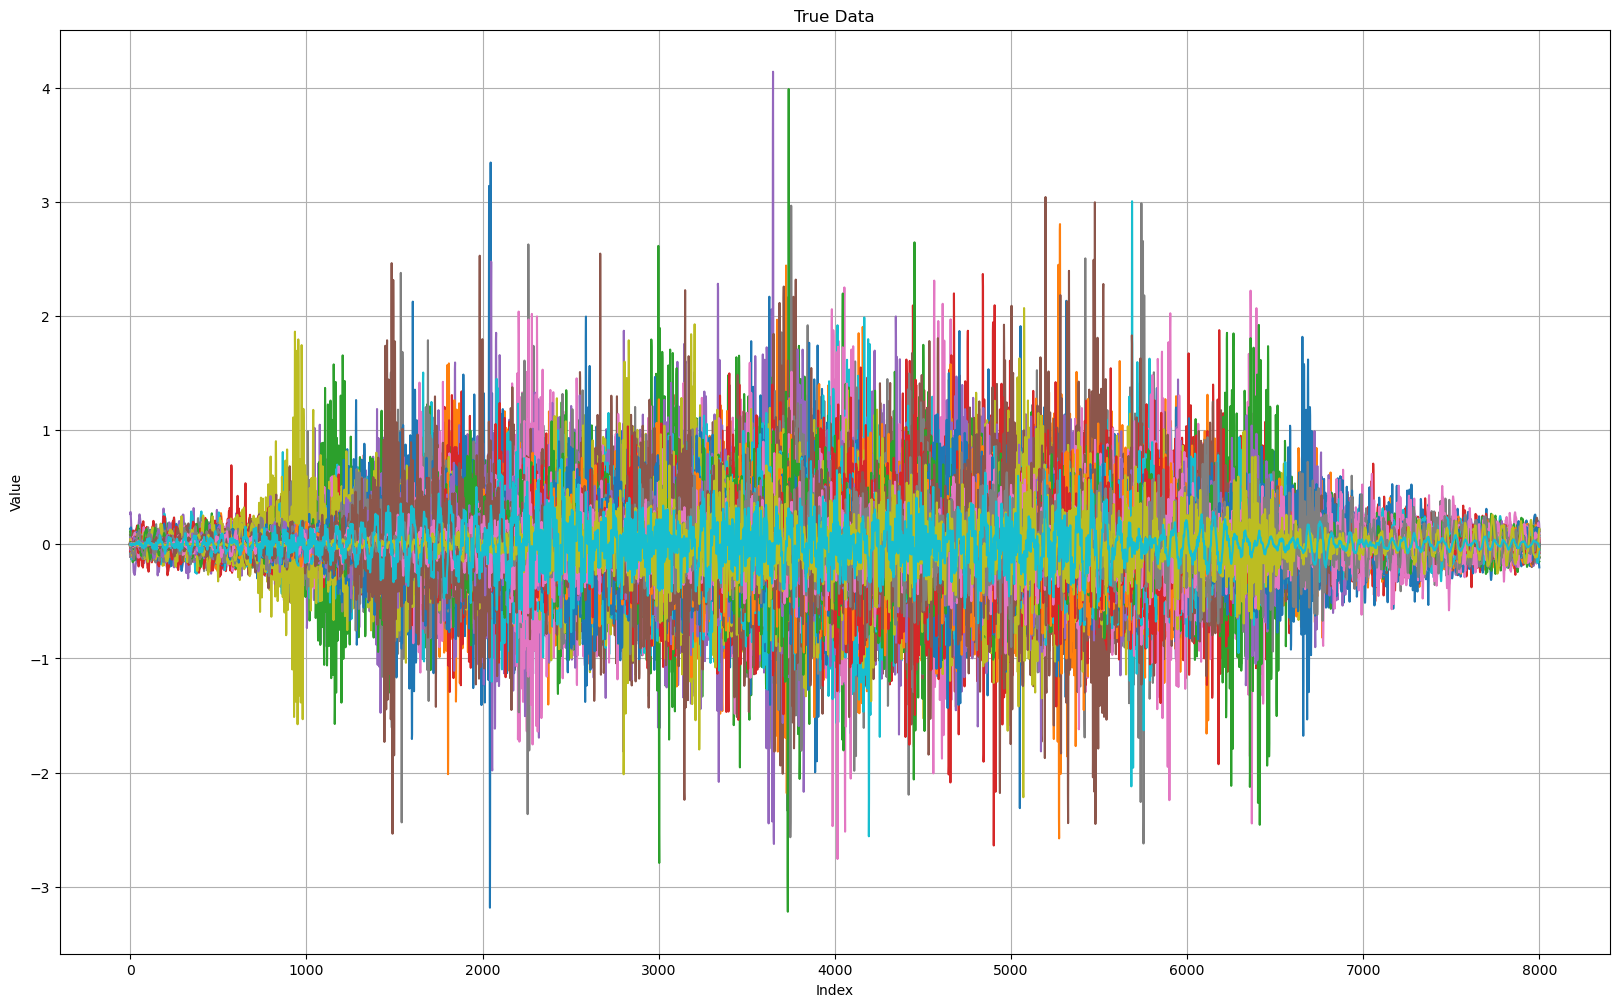

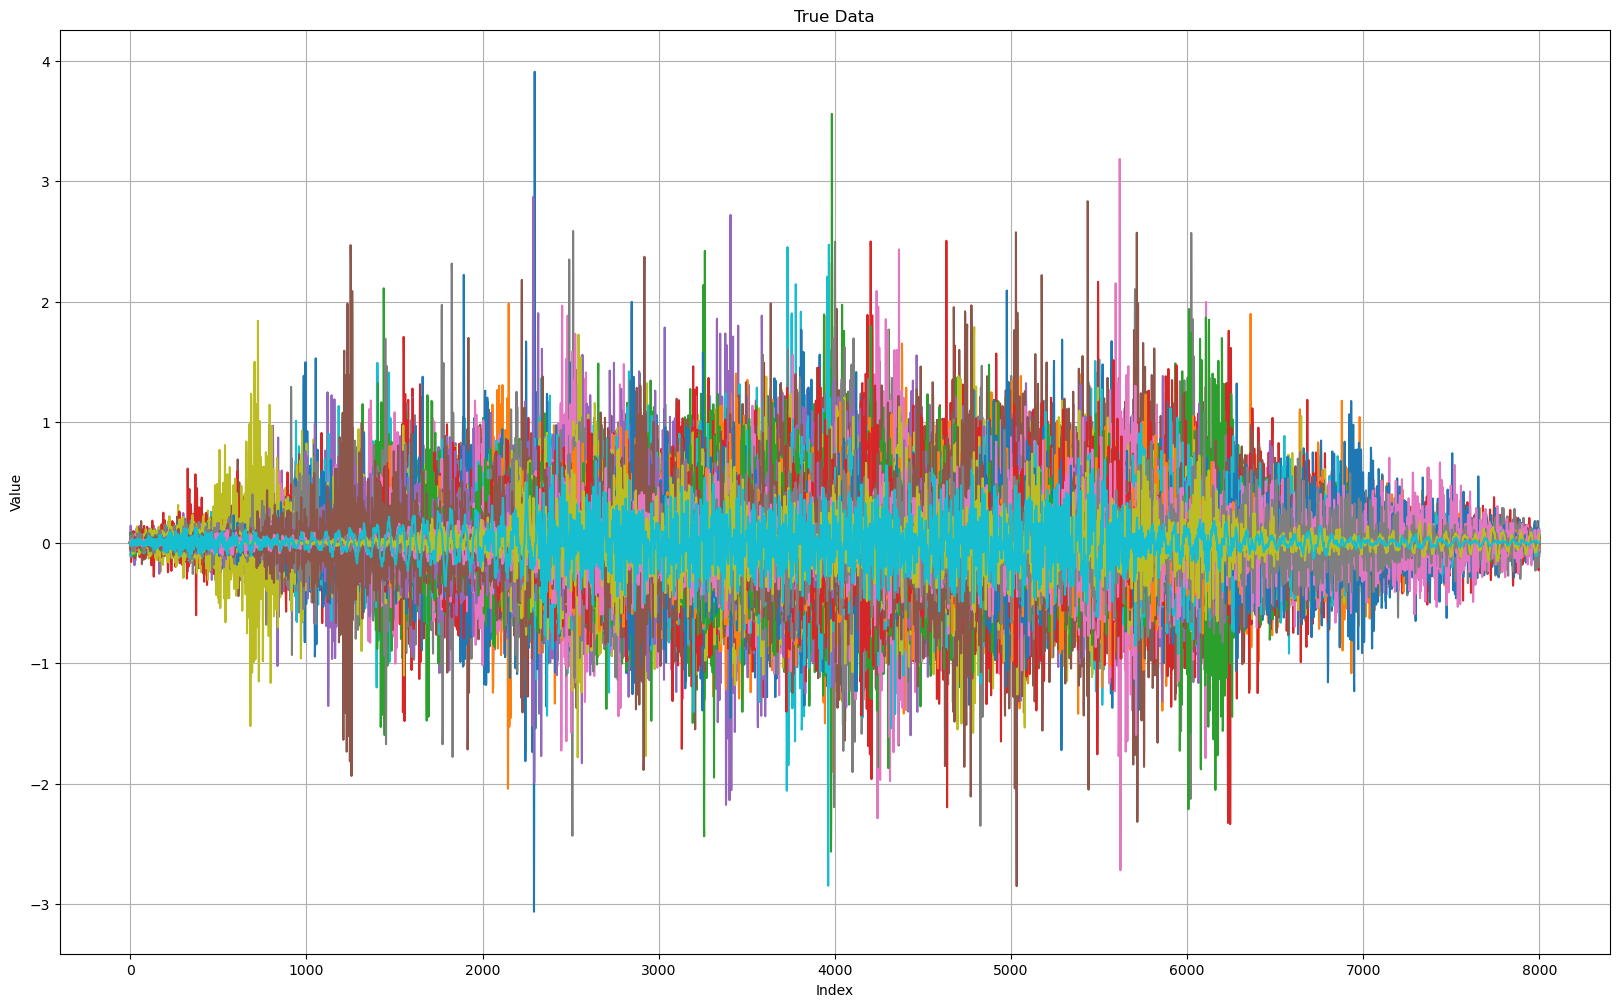

In [12]:
plt.figure(figsize=(20, 12))
for key in data_training:
    plt.plot(data_training[key]['A2'])
    plt.title('True Data')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
plt.show()

plt.figure(figsize=(20, 12))
for key in data_training:
    plt.plot(data_training[key]['A5'])
    plt.title('True Data')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
plt.show()



In [13]:
for key in data_training_Y.keys():
    if len(data_training_Y[key]) < 17:
        # pad the data with 0 to make the length of the data is 21
        data_training_Y[key] = np.pad(data_training_Y[key], (0, 17-len(data_training_Y[key])), 'constant')

for key in data_testing_Y.keys():
    if len(data_testing_Y[key]) < 17:
        # pad the data with 0 to make the length of the data is 21
        data_testing_Y[key] = np.pad(data_testing_Y[key], (0, 17-len(data_testing_Y[key])), 'constant')


# delete the frist row of the data_training_Y and data_testing_Y
drop_samll = True
if drop_samll:
    for key in data_training_Y:
        data_training_Y[key] = data_training_Y[key][1:]
    for key in data_testing_Y:
        data_testing_Y[key] = data_testing_Y[key][1:]

# put all arrays in the data_training_X in one tensor with shape of (number of data, 4500, 1) and igore the key of the dictionary
data_training_X = np.array([data_training_X[key] for key in data_training_X])
data_training_Y = np.array([data_training_Y[key]for key in data_training_Y])
data_training_speed = np.array([data_training_speed[key][0] for key in data_training_speed])


# put all arrays in the data_testing_X in one tensor with shape of (number of data, 4500, 1) and igore the key of the dictionary
data_testing_X = np.array([data_testing_X[key] for key in data_testing_X])
data_testing_Y = np.array([data_testing_Y[key] for key in data_testing_Y])
data_testing_speed = np.array([data_testing_speed[key][0] for key in data_testing_speed])

#len(data_training_Y[8]),len(data_testing_Y[164])




# reshape the speed_train and speed_test to (1,180) from (180,)
data_training_speed = data_training_speed.reshape(-1,1)
data_testing_speed = data_testing_speed.reshape(-1,1)

# normalize the speed_train and speed_test
speed_scaler = MinMaxScaler(feature_range=(0, 2))
data_training_speed = speed_scaler.fit_transform(data_training_speed)
data_testing_speed = speed_scaler.transform(data_testing_speed )


#print(data_testing_X.shape,data_testing_Y.shape,data_training_X.shape,data_training_Y.shape)
print(data_testing_X.shape,data_testing_Y.shape,data_training_X.shape,data_training_Y.shape,data_training_speed.shape,data_testing_speed.shape)

(20, 8000, 4) (20, 16) (180, 8000, 4) (180, 16) (180, 1) (20, 1)


In [14]:
400/2.5

160.0

In [15]:
# Training parameters
batch_size = 64
epochs = 12
BatchNorm = True 
normal = True 
regularization_rate = 8e-5
# Initial learning rate
initial_learning_rate = 0.0002
learning_rate_scheduler = False

In [16]:

kernels = [9, 5, 3]  # kernel sizes for each conv layer
strides = [3, 3, 1]  # stride values for each conv layer
pools = [2, 2, 2]    # pool sizes for each pooling layer after the conv layer

receptive_field = calculate_receptive_field(kernels, strides, pools)
print(f"The receptive field of the network is: {receptive_field}")

The receptive field of the network is: 162


In [17]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.optimizers import Adam


# Define exponential decay function
lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=50,
        decay_rate=0.9,
        staircase=True
        )
if learning_rate_scheduler:
    # Configure the Adam optimizer with the learning rate schedule
    optimizer = Adam(
        learning_rate=lr_schedule,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08
    )
else:
    # Configure the Adam optimizer with the initial learning rate
    optimizer = Adam(
        learning_rate=initial_learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08
    )



In [18]:
# create a early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)


In [19]:
# Seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Assuming the scalar data is a single value or a small set of values
scalar_input = Input(shape=(1,))  # Adjust the shape based on your scalar data
# Map scalar input to a higher-dimensional space
scalar_dense = Dense(16, activation='relu',kernel_initializer=initializers.GlorotUniform(seed=42))(scalar_input)


# Define input shape
input_shape = data_training_X.shape[1:]  # Adjust as per your data

# Input layer
inputs = Input(shape=input_shape)


# First Convolutional Block 

x = BatchNormalization()(inputs)
x = Activation('relu')(x)

x = Conv1D(filters=32, kernel_size=9, strides=3, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)

x = MaxPooling1D(pool_size=2)(x)
#x = LayerNormalization()(x)
# Add residual connection
x1 = Conv1D(filters=32, kernel_size=1, strides=3, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(inputs)  # Adjust filters and strides to match x
x1 = MaxPooling1D(pool_size=2)(x1)  # Add same pooling as x
x = Add()([x, x1])



# second Convolutional Block
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(filters=32, kernel_size=5, strides=3, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)

x = MaxPooling1D(pool_size=2)(x)
# layer normalization
#x = LayerNormalization()(x)

# Add residual connection
x2 = Conv1D(filters=32, kernel_size=1, strides=3, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(x1)  # Adjust filters and strides to match x
x2 = MaxPooling1D(pool_size=2)(x2)  # Add same pooling as x
x = Add()([x, x2])



# third Convolutional Block32
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(filters=16, kernel_size=3, strides=2, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)

x = MaxPooling1D(pool_size=2, strides=2, padding='valid')(x)
#x = LayerNormalization()(x)
# Add residual connection
x3 = Conv1D(filters=16, kernel_size=1, strides=2, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(x2)  # Adjust filters and strides to match x
x3 = MaxPooling1D(pool_size=2)(x3)  # Add same pooling as x
x = Add()([x, x3])



# Multi-Head Attention

seq_length = x.shape[1]  # Depends on previous layers' output shape
feature_dim = x.shape[2]  # The number of filters in the last Conv layer


# Assuming 'x' is the input to the attention layer
attention_layer = MultiHeadAttention(num_heads=3, key_dim=feature_dim, kernel_initializer=initializers.GlorotUniform(seed=42))
attention_output, attention_scores = attention_layer(x, x, x, return_attention_scores=True)


# Flattening the output to feed into a dense layer
flat = Flatten()(attention_output)
dense = Dropout(0.25)(flat)


# Concatenate scalar features and flattened sequence features
concat = concatenate([dense, scalar_dense])

# normalize the concatenated data

#concat = BatchNormalization()(concat)


# Final Dense Layers

dense = Dense(32, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=42))(concat)
outputs = Dense(units=16, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=42))(dense) 




# Create model with two inputs
CNN_model = Model(inputs=[inputs, scalar_input], outputs=outputs)

# Compile the model
#model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_squared_error'])
#model.compile(optimizer='Adam', loss=weighted_mse_exponential, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_exponential_normal_distribution, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_log_normal_distribution, metrics=['mean_squared_error'])

CNN_model.compile(optimizer=optimizer, loss=custom_loss, metrics=['mean_squared_error'])

# Display the model summary to check the architecture
CNN_model.summary()

"""# Apply the custom weighting
weighted_predictions = WeightApplication()([dense, scalar_input])

# Final output layer
final_output = Dense(units=32, activation='relu')(weighted_predictions)
final_output = Dense(units=20, activation='relu')(final_output)

# Model definition
model = Model(inputs=[inputs, scalar_input], outputs=final_output)
model.compile(optimizer='Adam', loss=custom_loss, metrics=['mean_squared_error'])

# Model summary
model.summary()"""






Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8000, 4)]    0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 8000, 4)     16          ['input_2[0][0]']                
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 8000, 4)      0           ['batch_normalization[0][0]']    
                                                                                                  
 conv1d (Conv1D)                (None, 2667, 32)     1184        ['activation[0][0]']         

"# Apply the custom weighting\nweighted_predictions = WeightApplication()([dense, scalar_input])\n\n# Final output layer\nfinal_output = Dense(units=32, activation='relu')(weighted_predictions)\nfinal_output = Dense(units=20, activation='relu')(final_output)\n\n# Model definition\nmodel = Model(inputs=[inputs, scalar_input], outputs=final_output)\nmodel.compile(optimizer='Adam', loss=custom_loss, metrics=['mean_squared_error'])\n\n# Model summary\nmodel.summary()"

In [20]:
# Training 
CNN_history = CNN_model.fit(x=[data_training_X, data_training_speed], y=data_training_Y, batch_size=batch_size, epochs=155,
          verbose=1, validation_split=0.1, shuffle=False, callbacks=[early_stopping])

Epoch 1/155
3/3 [==============================] - 6s 217ms/step - loss: 10.3136 - mean_squared_error: 5.1596 - val_loss: 10.1919 - val_mean_squared_error: 5.0944
Epoch 2/155
3/3 [==============================] - 0s 26ms/step - loss: 10.1160 - mean_squared_error: 5.0649 - val_loss: 10.0880 - val_mean_squared_error: 5.0432
Epoch 3/155
3/3 [==============================] - 0s 24ms/step - loss: 9.8847 - mean_squared_error: 4.9557 - val_loss: 9.9738 - val_mean_squared_error: 4.9871
Epoch 4/155
3/3 [==============================] - 0s 30ms/step - loss: 9.5435 - mean_squared_error: 4.7966 - val_loss: 9.8396 - val_mean_squared_error: 4.9216
Epoch 5/155
3/3 [==============================] - 0s 24ms/step - loss: 9.1846 - mean_squared_error: 4.6346 - val_loss: 9.6729 - val_mean_squared_error: 4.8409
Epoch 6/155
3/3 [==============================] - 0s 30ms/step - loss: 8.6976 - mean_squared_error: 4.4265 - val_loss: 9.4639 - val_mean_squared_error: 4.7408
Epoch 7/155
3/3 [==================

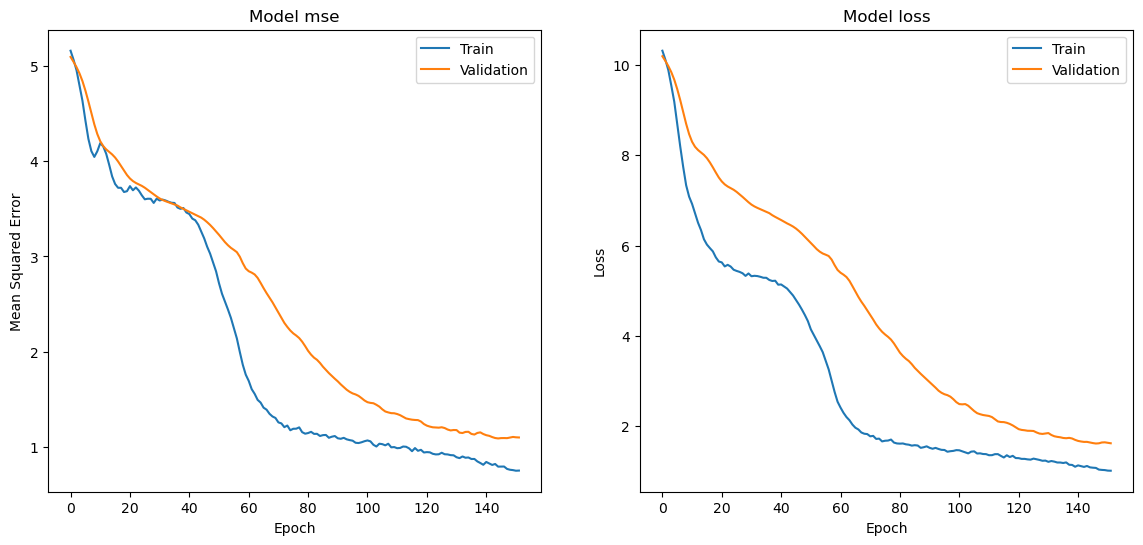

In [21]:
#plot the mse of the training and validation on the left(2,1) and the loss of the training and validation on the right(2,2)
figure = plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(CNN_history.history['mean_squared_error'][:])
plt.plot(CNN_history.history['val_mean_squared_error'][:])
plt.title('Model mse')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(CNN_history.history['loss'][:])
plt.plot(CNN_history.history['val_loss'][:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'],loc = 'upper right')

# save the figure to the file
#figure.savefig('model_loss5-1.png', dpi=500)
plt.show()

In [22]:
#set a timer to record the time of the prediction]
import time
start = time.time()
# predict the data_testing_X
CNN_y_pred = CNN_model.predict([data_testing_X,data_testing_speed])

end = time.time()
print("Time taken to predict the data_testing_X is ", end - start)
# Rounding the predictions
CNN_rounded_predictions = round_to_nearest_half(CNN_y_pred )


Time taken to predict the data_testing_X is  0.40250396728515625


In [23]:
# calculate the mse of prediction

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# calculate the mse of the prediction
CNN_mse = mean_squared_error(data_testing_Y, CNN_y_pred)

# calculate the custom loss of the prediction
CNN_custom_loss_value = custom_loss(data_testing_Y, CNN_y_pred)

# calculate the mean value of custom loss
CNN_mean_custom_loss = np.mean(CNN_custom_loss_value)

print('The mse of the prediction is ', CNN_mse)
print('The mean value of the custom loss is ', CNN_mean_custom_loss)

The mse of the prediction is  1.5559921
The mean value of the custom loss is  2.4594877


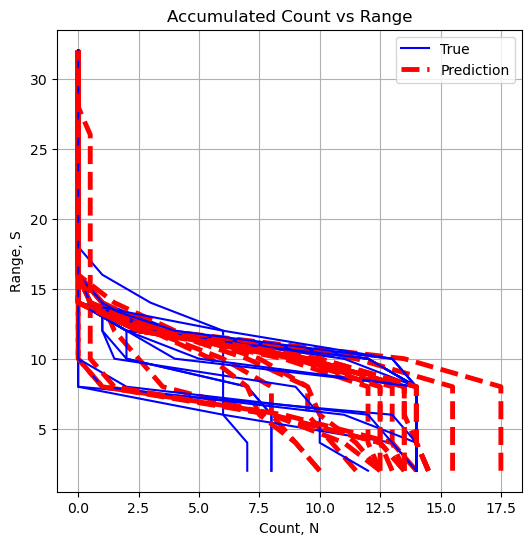

In [24]:
S = list(range(2,34,2))

# Plot all predictions on a same plot
figure = plt.figure(figsize=(6, 6))
for i in range(len(CNN_rounded_predictions)):
    pre_N = CNN_rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    #plt.semilogx(Ncum, S, color = 'blue')
    plt.plot(Ncum, S, color = 'blue',linewidth=1.5, label='True')
    #plt.semilogx(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5)
    plt.plot(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5, label='Prediction')
    #plt.title('train number = '+str(test_num[i]))
    # plot the one sigma error bar
    #plt.fill_betweenx(S, pre_Ncum - one_sigma, pre_Ncum + one_sigma, color='red', alpha=0.05)
    plt.xlabel('Count, N')
    plt.ylabel('Range, S')
    #plt.legend()
    plt.grid(True)
    if i == 0:
        plt.legend()
    plt.title('Accumulated Count vs Range')
# save the figure to the file
#figure.savefig('predts 5-1', dpi=500)
# add a test to the plot to show the color of the line

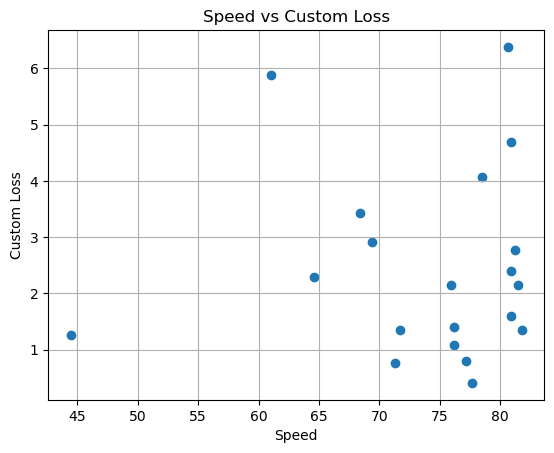

In [25]:
# denormalize the train speeds
#data_training_speed = speed_scaler.inverse_transform(data_training_speed)
denormailzed_data_testing_speed = speed_scaler.inverse_transform(data_testing_speed)

plt.scatter(denormailzed_data_testing_speed,CNN_custom_loss_value)
plt.xlabel('Speed')
plt.ylabel('Custom Loss')
plt.title('Speed vs Custom Loss')
plt.grid(True)
# save the figure to the file
#plt.savefig('Speed vs Custom Loss 5-1', dpi=500)
plt.show()

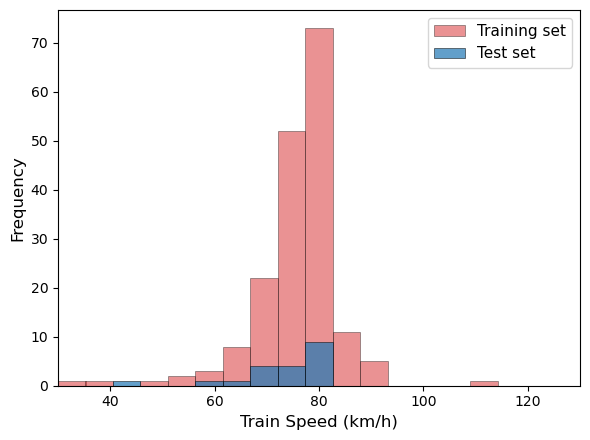

In [29]:


plt.figure(figsize=(6, 4.5))

# Use consistent bins and a range for comparison
bins = np.linspace(30, 130, 20)

# Plot histograms
plt.hist(speed_scaler.inverse_transform(data_training_speed), bins=bins, alpha=0.5,
         label='Training set', color='tab:red', edgecolor='black', linewidth=0.5)

plt.hist(denormailzed_data_testing_speed, bins=bins, alpha=0.7,
         label='Test set', color='tab:blue', edgecolor='black', linewidth=0.5)

# Labels and legend
plt.xlabel('Train Speed (km/h)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
#plt.title('Distribution of Train Velocities', fontsize=13)
plt.legend(fontsize=11)
plt.xlim(30, 130)
plt.grid(False)
plt.tight_layout()

# save the figure to svg file
plt.savefig('Figure14.svg', dpi=500, format='svg')

plt.show()



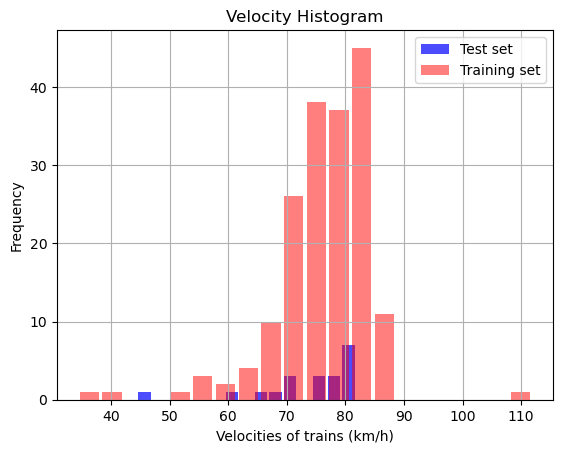

In [55]:
# plot the histogram of the denormailzed_data_testing_speed
plt.hist(denormailzed_data_testing_speed, bins=15, alpha=0.7, rwidth=0.85, color='blue',label='Test set')
plt.hist(speed_scaler.inverse_transform(data_training_speed), bins=20, alpha=0.5, rwidth=0.85, color='red',label='Training set')
plt.xlabel('Velocities of trains (km/h)')
plt.ylabel('Frequency')
plt.title('Velocity Histogram')
plt.legend()
plt.grid(True)
# save the figure to the file
#plt.savefig('Speed Histogram 5-1', dpi=500)

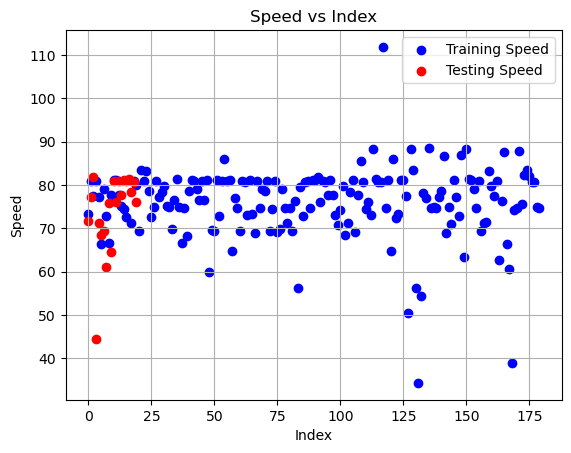

In [56]:
plt.scatter(range(0,len(data_training_speed)),speed_scaler.inverse_transform(data_training_speed),label='Training Speed',color='blue')
plt.scatter(range(0,len(denormailzed_data_testing_speed)),denormailzed_data_testing_speed,label='Testing Speed',color='red')
plt.xlabel('Index')
plt.ylabel('Speed')
plt.title('Speed vs Index')
plt.legend()
plt.grid(True)



Text(0.09, 0.5, 'Stress Range, S')

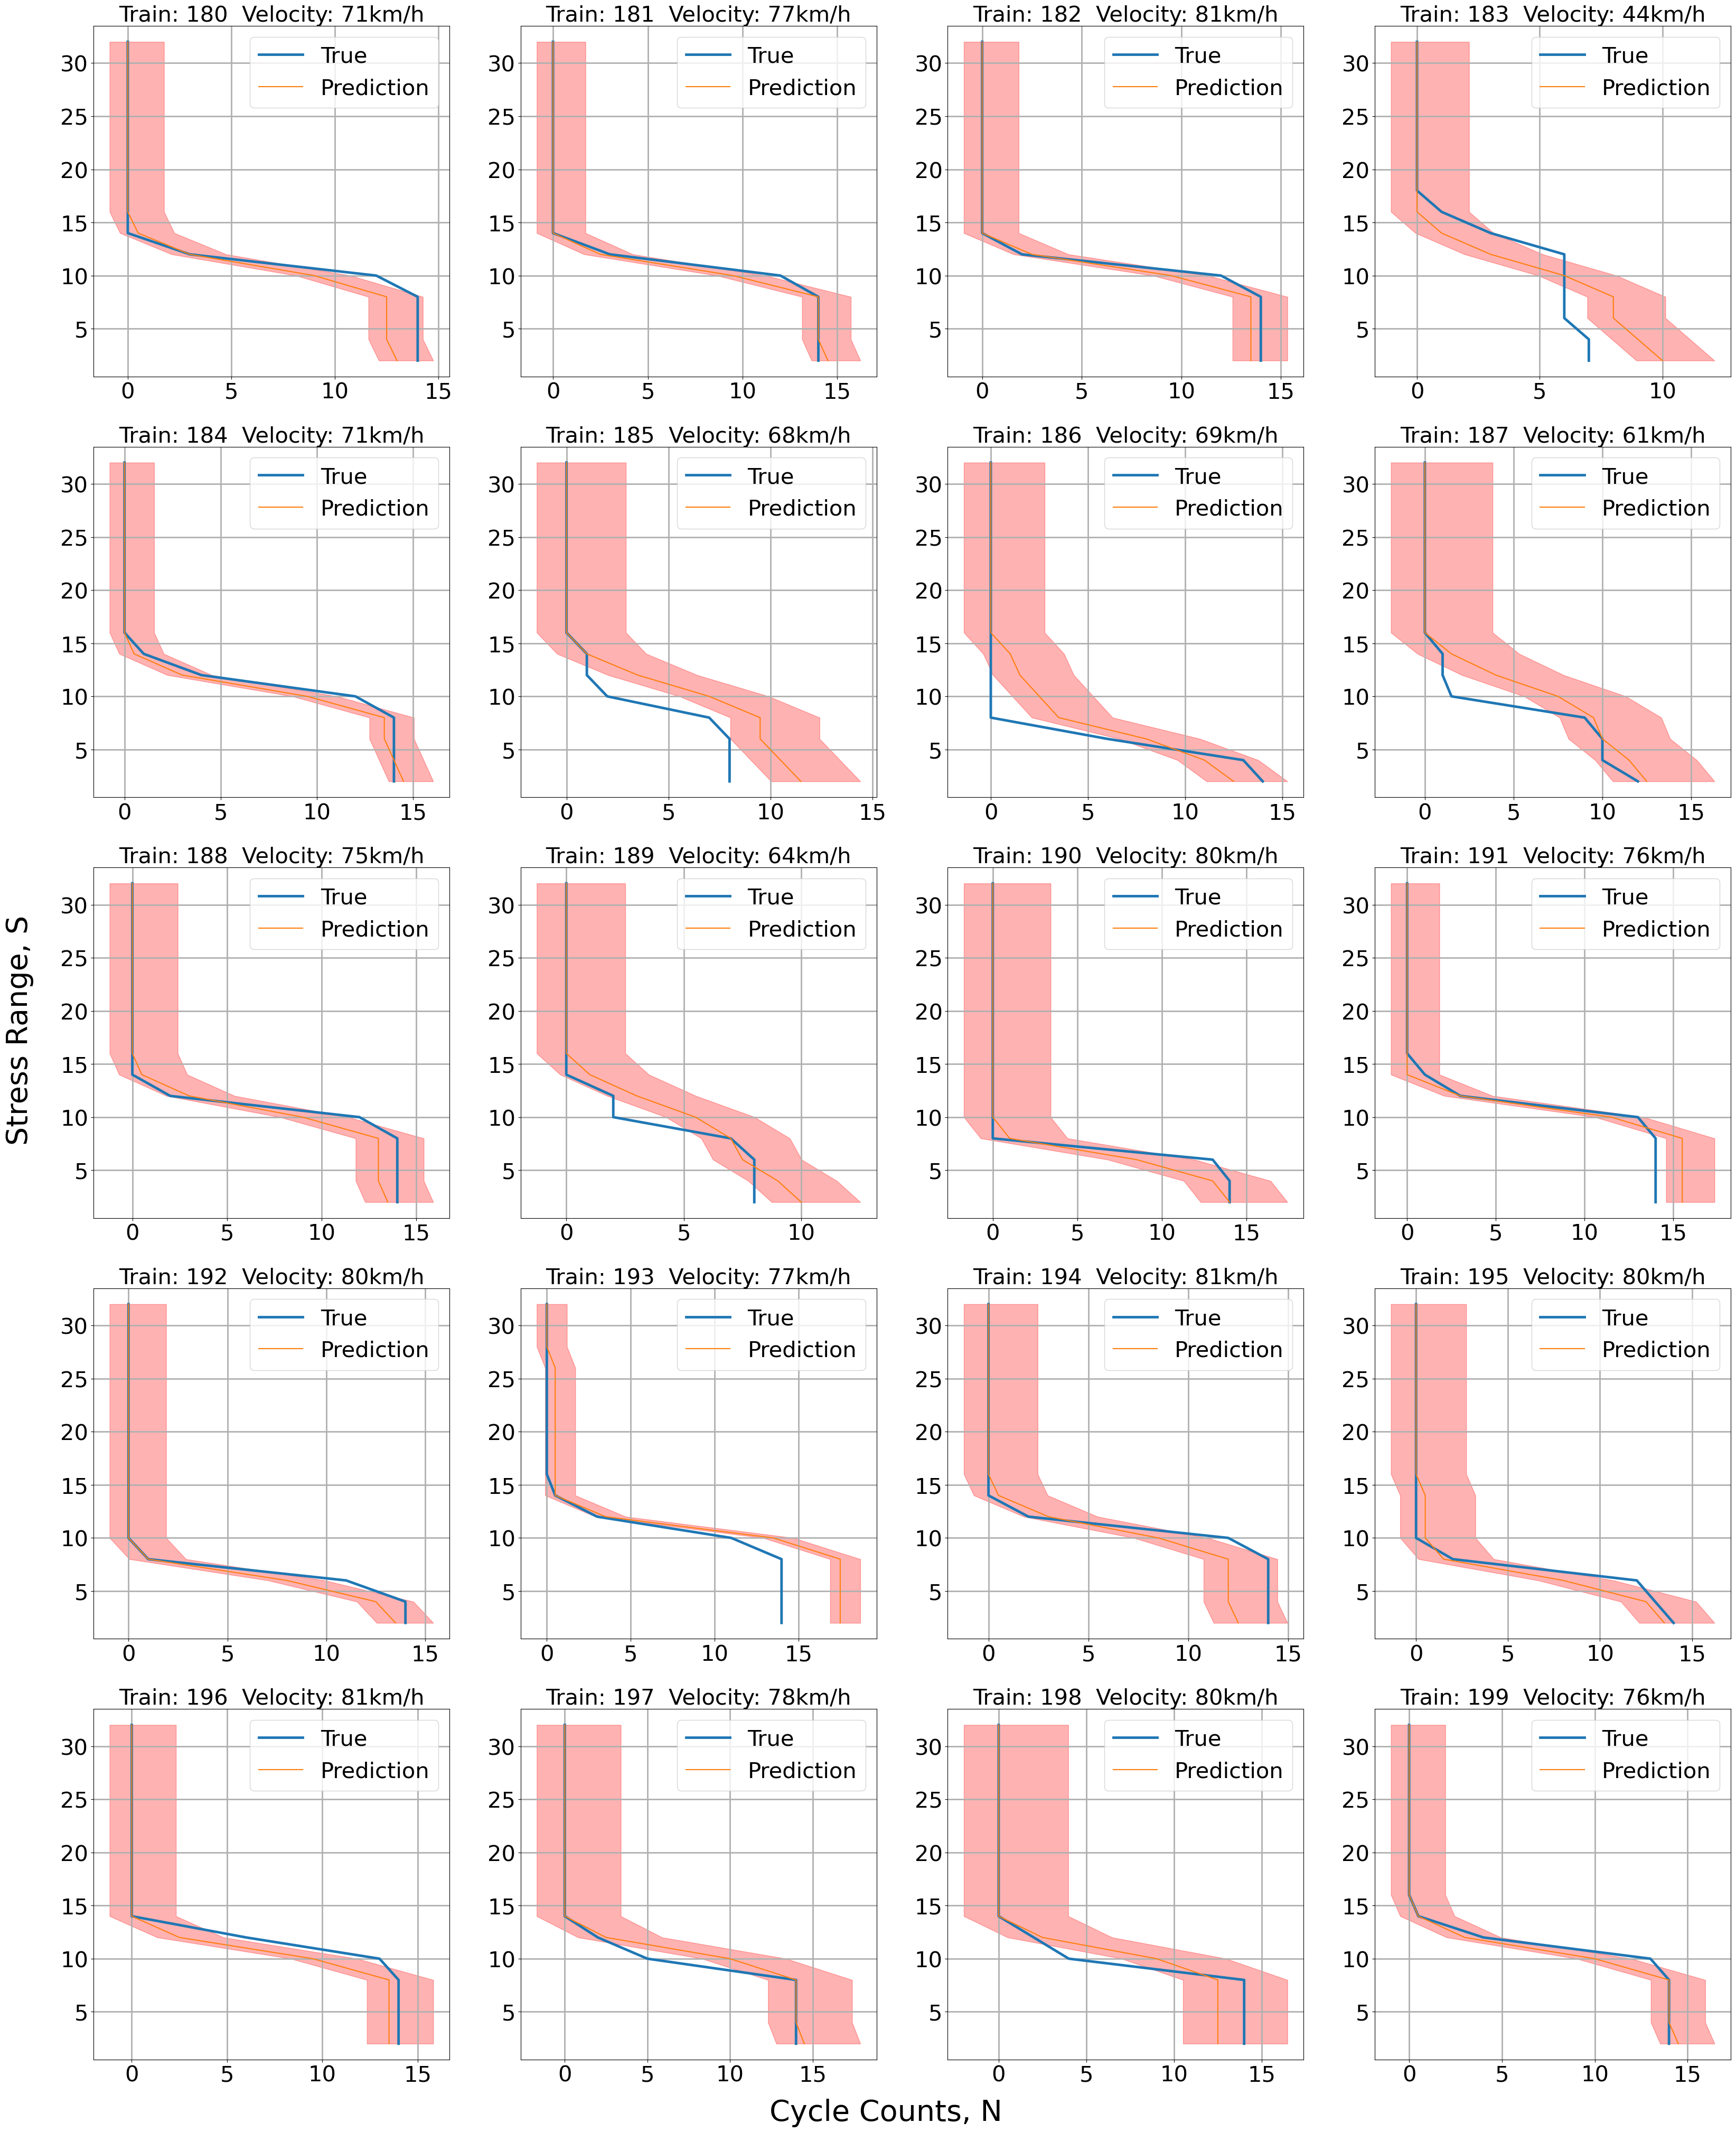

In [30]:
# plot all predictions on a plot with the same color
S = list(range(2,34,2))
figure, axes = plt.subplots(5, 4, figsize=(40, 50))

for i in range(len(CNN_rounded_predictions)):
    pre_N = CNN_rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    # calculate the one sigma of the prediction
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    ax = axes[i//4, i%4]
    ax.plot(Ncum, S, label='True',linewidth=3.5)
    # plot the two sigma of the prediction
    ax.fill_betweenx(S, pre_Ncum-1*one_sigma, pre_Ncum+2*one_sigma, color='r', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma, pre_Ncum+1*one_sigma-2*one_sigma, color='y', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum+1*one_sigma, pre_Ncum+2*one_sigma, color='y', alpha=0.3)

    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma-3*one_sigma, pre_Ncum+2*one_sigma+3*one_sigma, color='b', alpha=0.1)

    ax.plot(pre_Ncum, S, label='Prediction', linewidth=1.5)
    # set the title of the plot to show the train number and train velocity
    ax.set_title('Train: '+str(test_num[i])+'  Velocity: '+str(int(denormailzed_data_testing_speed[i][0])) +'km/h',fontsize=30)
    #ax.set_xlabel('Count, N')
    #ax.set_ylabel('Range, S')
    # make the font size of label and title bigger
    ax.tick_params(axis='both', which='major', labelsize=30)
    # make the font size of x and y notations bigger
    ax.title.set_size(30)
    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)

    # make the legend bigger
    ax.legend(prop={'size': 30})

    ax.grid(True, linewidth=2)
# Set common labels
figure.text(0.5, 0.09, 'Cycle Counts, N', ha='center', va='center', fontsize=40)
figure.text(0.09, 0.5, 'Stress Range, S', ha='center', va='center', rotation='vertical', fontsize=40)
# save the figure to the file
#figure.savefig('predictions 5-1', dpi=500)

Text(0.09, 0.5, 'Stress Range, S')

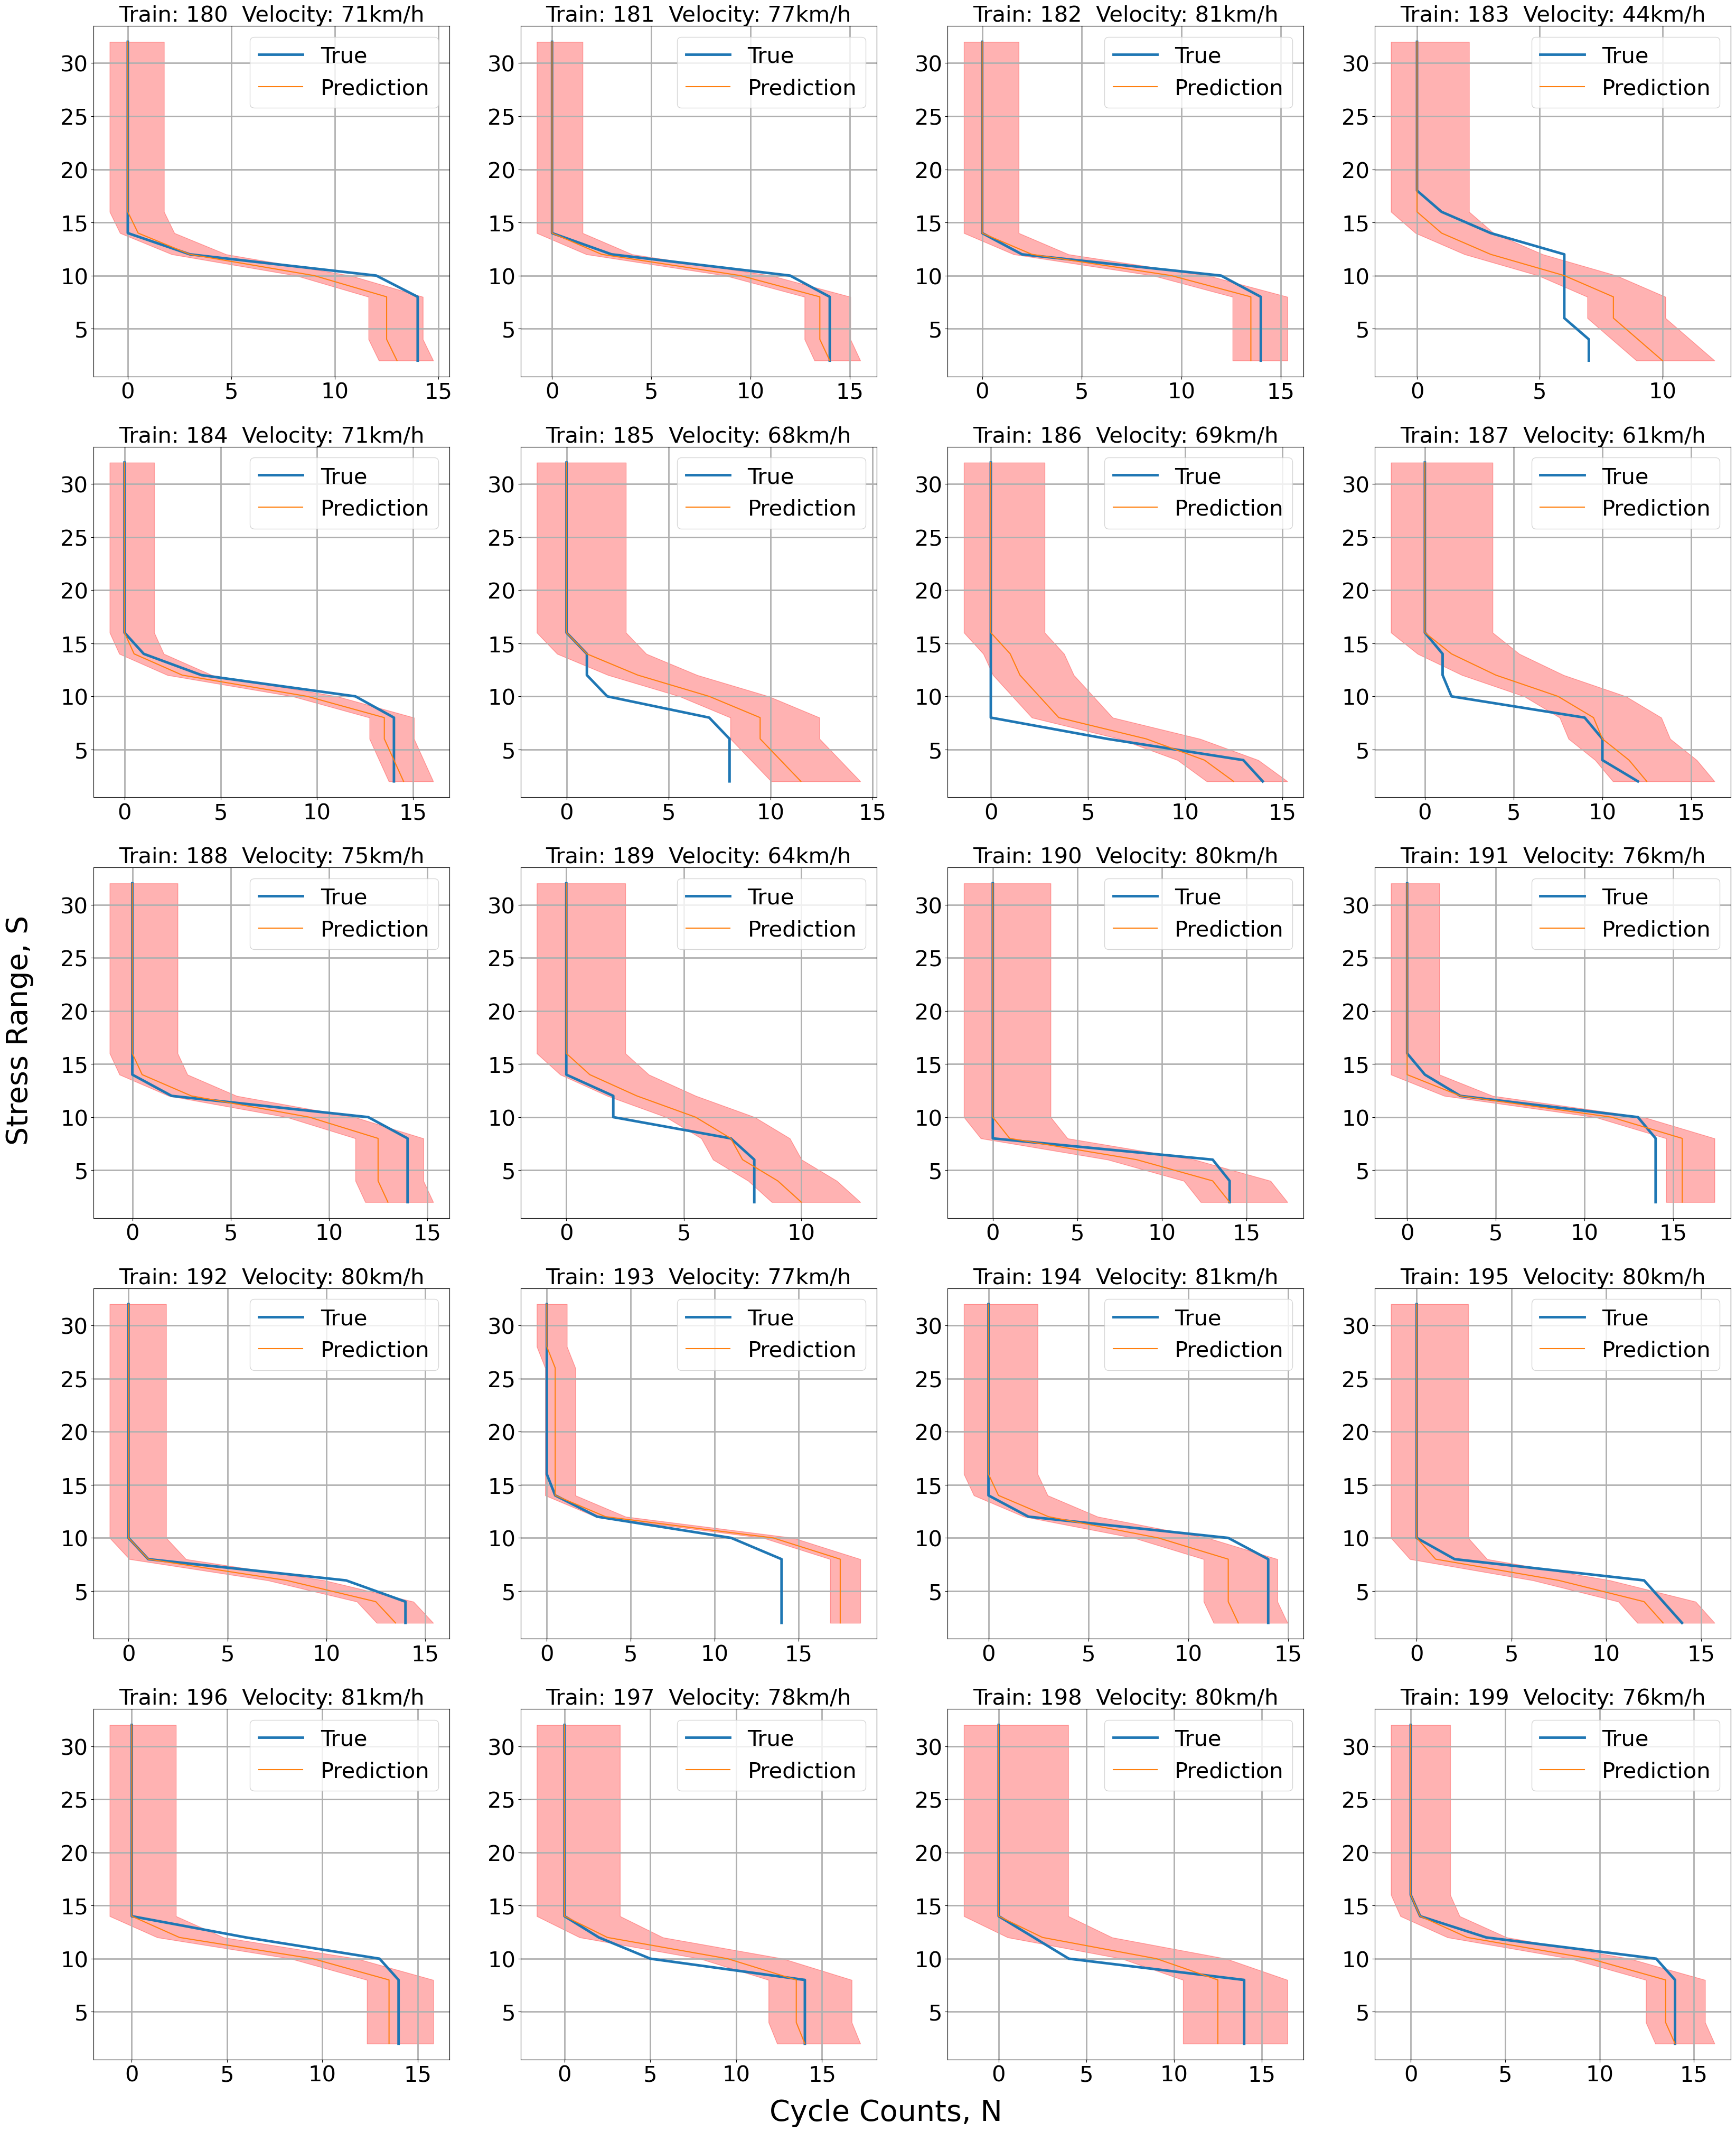

In [58]:
# plot all predictions on a plot with the same color
S = list(range(2,34,2))
figure, axes = plt.subplots(5, 4, figsize=(40, 50))

for i in range(len(CNN_rounded_predictions)):
    pre_N = CNN_rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    # calculate the one sigma of the prediction
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    ax = axes[i//4, i%4]
    ax.plot(Ncum, S, label='True',linewidth=3.5)
    # plot the two sigma of the prediction
    ax.fill_betweenx(S, pre_Ncum-1*one_sigma, pre_Ncum+2*one_sigma, color='r', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma, pre_Ncum+1*one_sigma-2*one_sigma, color='y', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum+1*one_sigma, pre_Ncum+2*one_sigma, color='y', alpha=0.3)

    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma-3*one_sigma, pre_Ncum+2*one_sigma+3*one_sigma, color='b', alpha=0.1)

    ax.plot(pre_Ncum, S, label='Prediction', linewidth=1.5)
    # set the title of the plot to show the train number and train velocity
    ax.set_title('Train: '+str(test_num[i])+'  Velocity: '+str(int(denormailzed_data_testing_speed[i][0])) +'km/h',fontsize=30)
    #ax.set_xlabel('Count, N')
    #ax.set_ylabel('Range, S')
    # make the font size of label and title bigger
    ax.tick_params(axis='both', which='major', labelsize=30)
    # make the font size of x and y notations bigger
    ax.title.set_size(30)
    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)

    # make the legend bigger
    ax.legend(prop={'size': 30})

    ax.grid(True, linewidth=2)
# Set common labels
figure.text(0.5, 0.09, 'Cycle Counts, N', ha='center', va='center', fontsize=40)
figure.text(0.09, 0.5, 'Stress Range, S', ha='center', va='center', rotation='vertical', fontsize=40)
# save the figure to the file
#figure.savefig('predictions 5-1', dpi=500)

### averaged loss and averaged mse


In [ ]:

# Data setup
averaged_mse = [1.0740185, 1.43746555, 1.69215715, 1.60226235, 1.41449905, 1.09831565, 1.6647238, 1.4744086, 1.106058, 1.50090195]
averaged_loss = [1.434921633, 1.78881455, 2.46918475, 2.2651433, 2.14153095, 1.71608625, 2.71902835, 2.0547334, 1.4749742, 2.3147286]
indices = np.arange(len(averaged_mse))
indices = indices + 1

# Creating a DataFrame
df = pd.DataFrame({
    'Cross Validation Index': indices,
    'MSE': averaged_mse,
    'Weighted MSE': averaged_loss
})

# Melting the DataFrame for easier plotting with Seaborn
df_melted = df.melt(id_vars=['Cross Validation Index'], value_vars=['MSE', 'Weighted MSE'], var_name='Metric', value_name='Value')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Cross Validation Index', y='Value', hue='Metric', data=df_melted)
plt.title('Comparison of MSE and Weighted MSE for 10-Fold Cross Validation', fontsize=16)
plt.xlabel('Cross Validation Index', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.xticks(fontsize=16 )
plt.yticks(fontsize=16)
plt.legend(title='Metric', title_fontsize='12', fontsize='12')
sns.set_style("whitegrid")


# Find and mark the maximum values
overall_mse = np.mean(averaged_mse)
overall_loss = np.mean(averaged_loss)

# Adding lines and text annotations for max values
plt.axhline(overall_mse, color='r', linestyle='--')
plt.axhline(overall_loss, color='r', linestyle='--')
plt.text(-0.5, overall_mse+0.1, f'Averaged MSE: {overall_mse:.2f}', color='Black', ha='left', va='bottom',fontdict={'fontsize': 14})
plt.text(-0.5, overall_loss+0.1, f'Averaged Weighted MSE: {overall_loss:.2f}', color='black', ha='left', va='bottom',fontdict={'fontsize': 14})


# Add red arrows showing the difference to the average
for i, (mse, loss) in enumerate(zip(averaged_mse, averaged_loss)):
    plt.annotate('', xy=(i-0.2, mse), xytext=(i-0.2, overall_mse),
                 arrowprops=dict(arrowstyle="<-, head_width=0.2, head_length=0.5", facecolor='red', edgecolor='red'))
    plt.annotate('', xy=(i+0.2, loss), xytext=(i+0.2, overall_loss ),
                 arrowprops=dict(arrowstyle="<-, head_width=0.2, head_length=0.5", facecolor='red', edgecolor='red'))


plt.show()


### visiulized the intermdiua output

In [64]:
test_num[0]

180

In [65]:
train_to_visualize = 180
test_num_visualize = 0

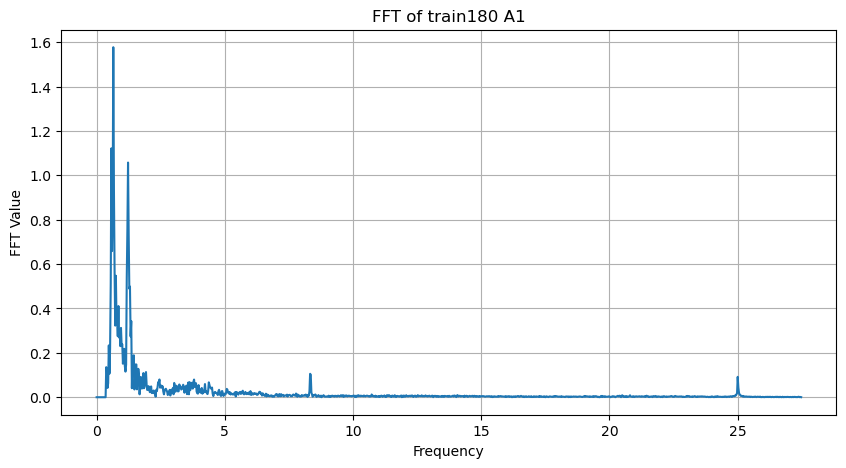

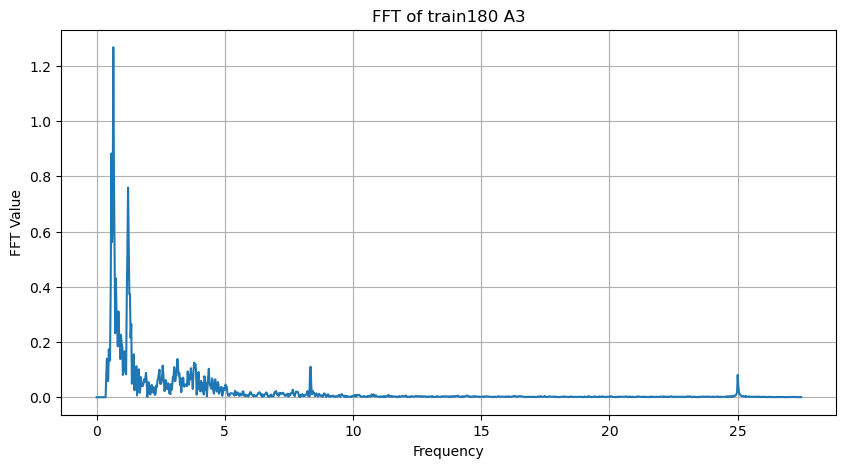

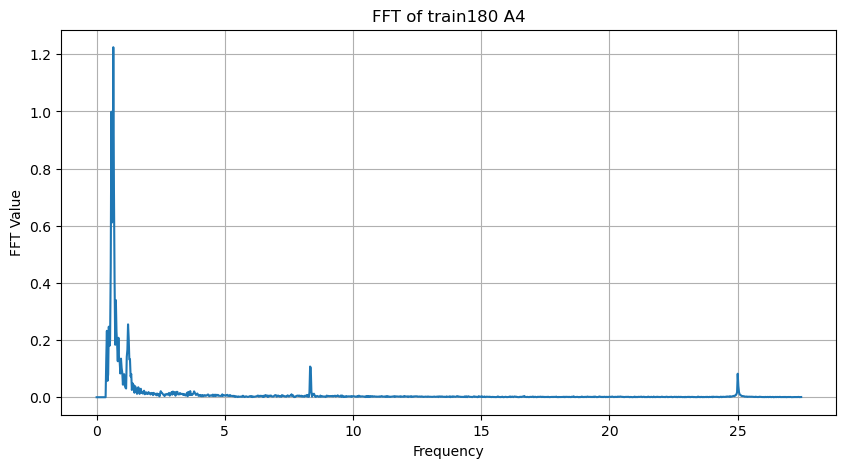

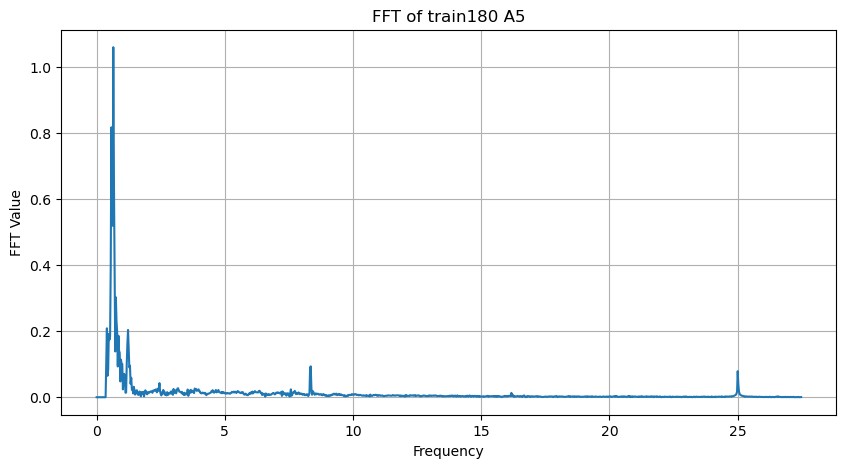

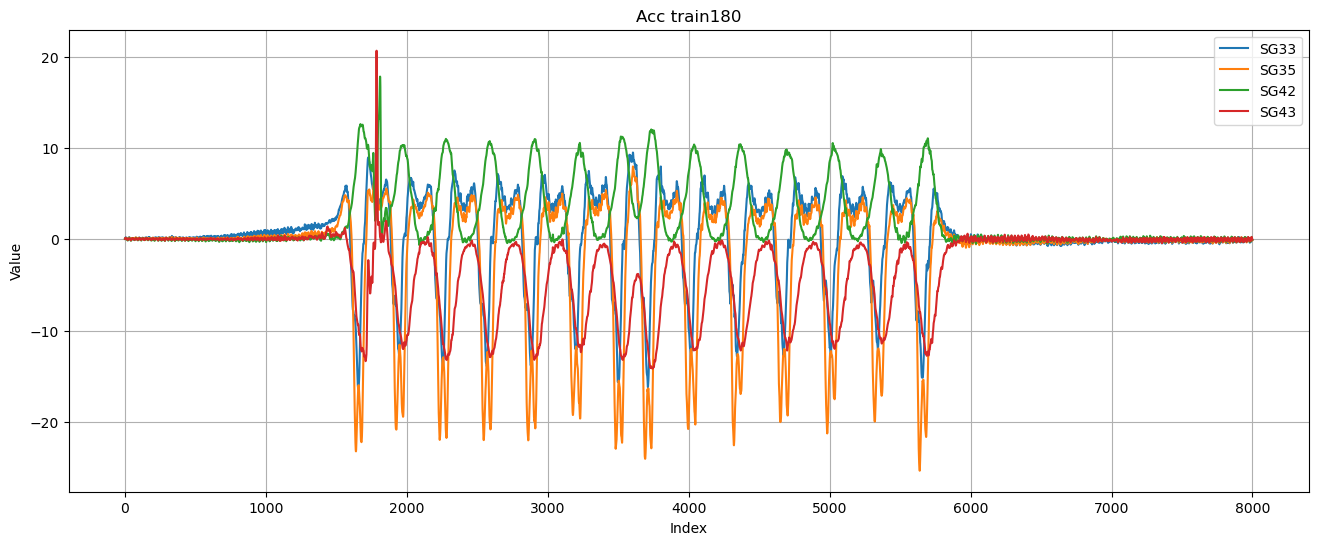

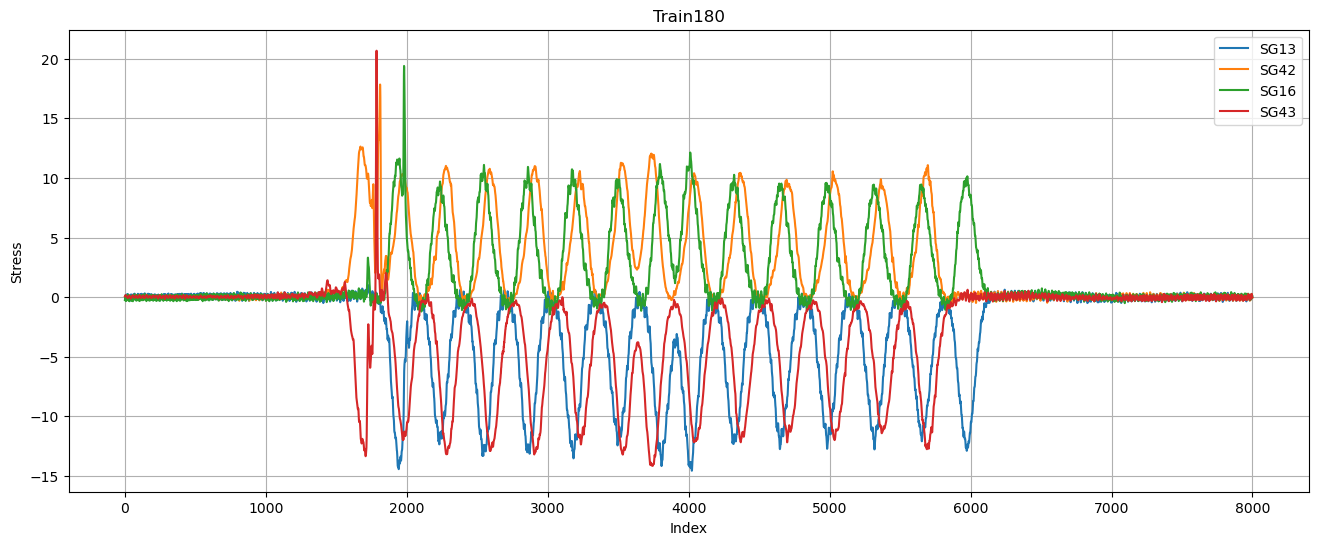

In [66]:
plot_fft(data_testing[train_to_visualize].iloc[:,0],title = "train"+ str(train_to_visualize) + ' A1', plot = 1100)
plot_fft(data_testing[train_to_visualize].iloc[:,1],title = "train"+ str(train_to_visualize) + ' A3', plot = 1100)
plot_fft(data_testing[train_to_visualize].iloc[:,2],title = "train"+ str(train_to_visualize) + ' A4', plot = 1100)
plot_fft(data_testing[train_to_visualize].iloc[:,3],title = "train"+ str(train_to_visualize) + ' A5', plot = 1100)

plt.figure(figsize=(16, 6))
for i in range(4,8,1):
    plt.plot(data_testing[train_to_visualize].iloc[:,i],label=data_testing[train_to_visualize].columns[i])
    plt.legend()
    plt.title('Acc '+str("train"+ str(train_to_visualize)))
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)


plt.figure(figsize=(16, 6))

#plt.plot(data_testing[24]['SG3'][0:],label='SG2')
plt.plot(data_testing[train_to_visualize]['SG13'][0:],label='SG13')
plt.plot(data_testing[train_to_visualize]['SG42'][0:],label='SG42')
plt.plot(data_testing[train_to_visualize]['SG16'][0:],label='SG16')
plt.plot(data_testing[train_to_visualize]['SG43'][0:],label='SG43')
plt.legend()
plt.title('Train'+str(train_to_visualize))
plt.xlabel('Index')
plt.ylabel('Stress')
plt.grid(True)
# save the figure to the file
#plt.savefig('Stress history of Train 0', dpi=500)

In [67]:
from tensorflow.keras.models import Model

# Existing model inputs and outputs
inputs = CNN_model.input

# Desired layers to visualize
#layer_outputs = [layer.output for layer in model.layers if isinstance(layer, (tf.keras.layers.Conv1D, tf.keras.layers.MaxPooling1D))]
layer_outputs = [layer.output for layer in CNN_model.layers if isinstance(layer, (tf.keras.layers.MaxPooling1D))]

# Create a model for visualization
#visualization_model = Model(inputs=inputs, outputs=layer_outputs)

visualization_model = Model(inputs=CNN_model.inputs, outputs=[layer_outputs, attention_scores])


# Now you can use this model to predict and see the outputs of the intermediate layers

import matplotlib.pyplot as plt


# Assuming data_testing_X is your main data and data_testing_speed is a scalar input
# Select a single sample from each and add a batch dimension
test_input_data = [np.expand_dims(data_testing_X[test_num_visualize], axis=0), np.expand_dims(data_testing_speed[test_num_visualize], axis=0)]

print(test_input_data[0].shape)  # Should show (1, length_of_sequence, num_features)
print(test_input_data[1].shape)  # Should show (1, number_of_scalar_features)



# Assuming you have a sample `test_input_data` ready
#test_input_data = [data_testing_X[0],data_testing_speed[0]]  # Replace with your actual test data

# Get the outputs of all the intermediate layers
#intermediate_outputs = visualization_model.predict(test_input_data)


# Make predictions and retrieve attention scores
intermediate_outputs, attention = visualization_model.predict(test_input_data)


(1, 8000, 4)
(1, 1)


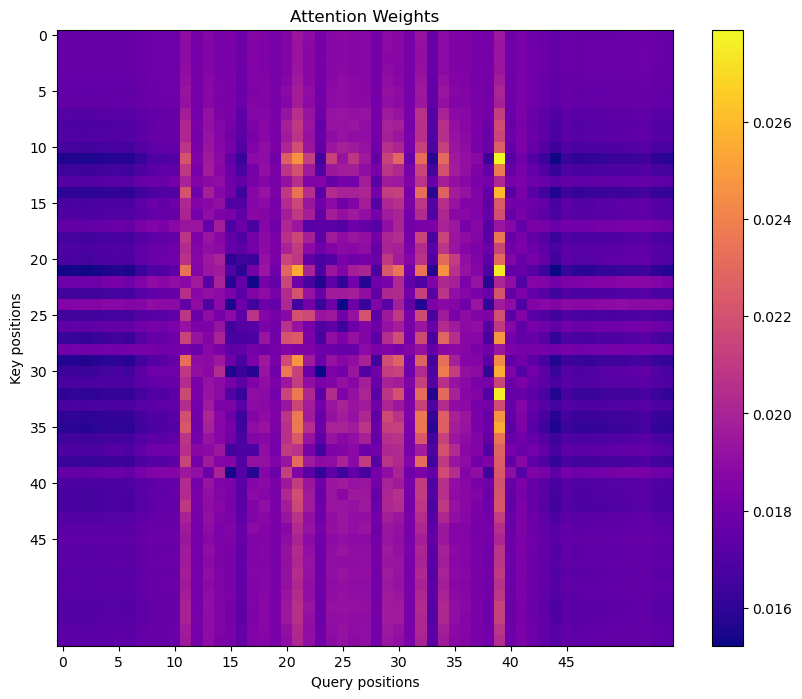

In [68]:
# Attention weights visualization, assuming first example and first attention head

# average attention[0, 0],attention[0, 1],attention[0, 2] and get the mean value

attention_weights = (attention[0, 0] + attention[0, 1] + attention[0, 2])/3
#attention_weights = attention[0, 0]

plt.figure(figsize=(10, 8))
## Display each attention weights as an image
plt.imshow(attention_weights, cmap='plasma', interpolation='nearest')
plt.colorbar()


plt.title('Attention Weights')
plt.xlabel('Query positions')
plt.ylabel('Key positions')
# make the x with more ticks

plt.xticks(range(0, 50, 5))
plt.yticks(range(0, 50, 5))
plt.show()

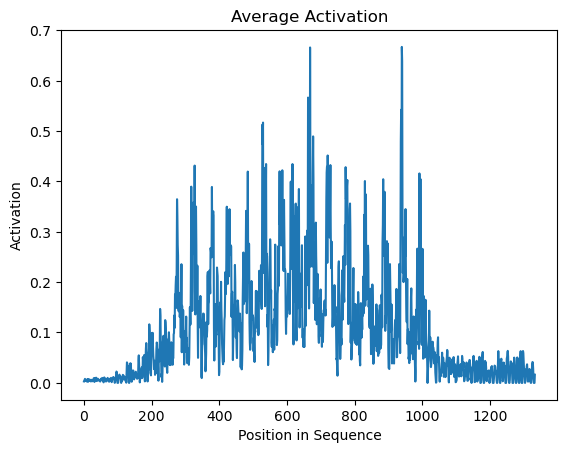

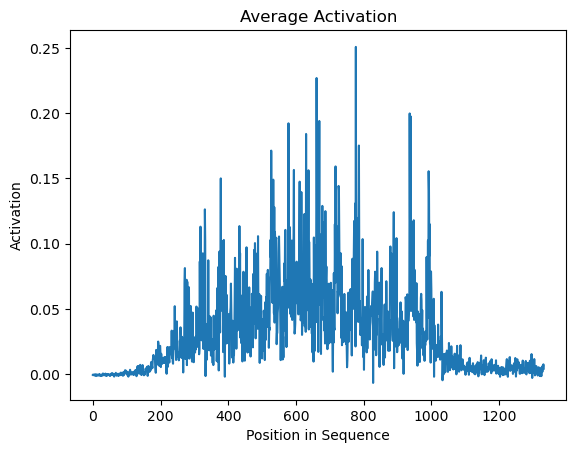

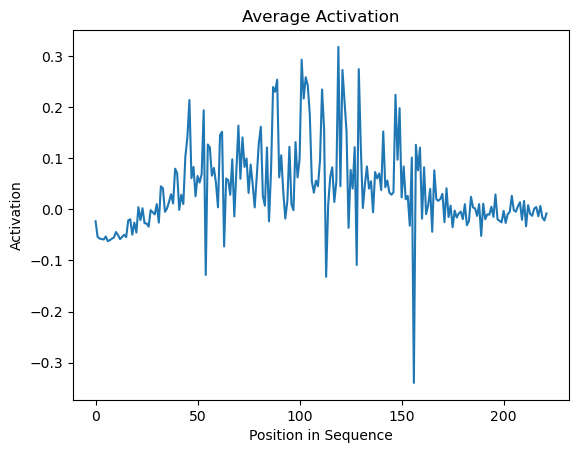

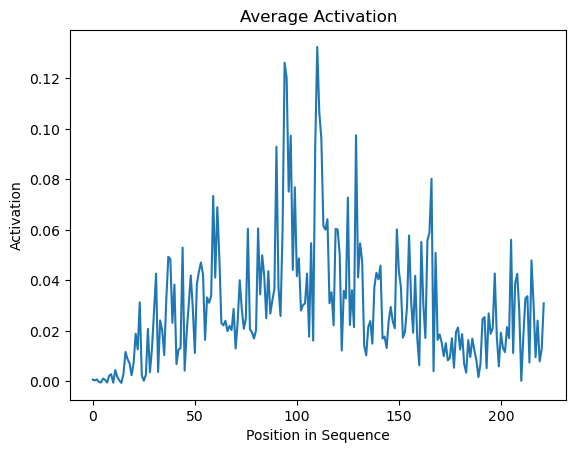

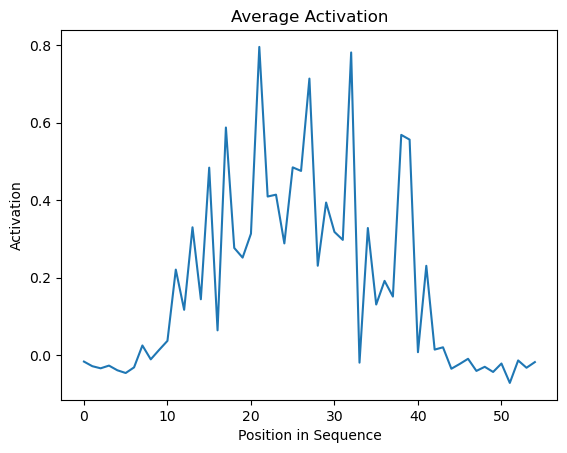

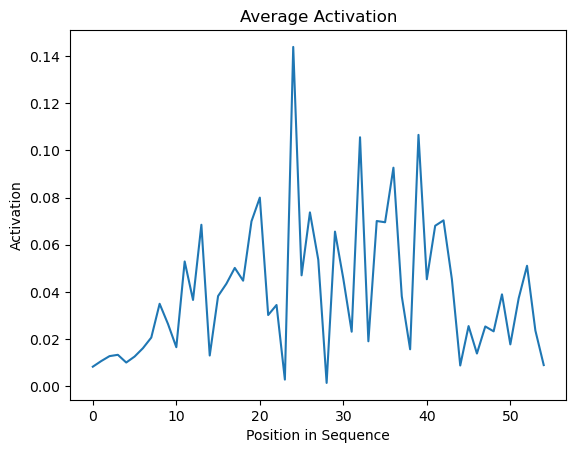

In [69]:
# Plot average activations across filters
for layer_activations in intermediate_outputs:
    avg_activation = np.mean(layer_activations[0], axis=-1)
    plt.plot(avg_activation)
    plt.title('Average Activation')
    plt.ylabel('Activation')
    plt.xlabel('Position in Sequence')
    plt.show()


In [70]:
layer_outputs = []
for layer in CNN_model.layers:
    if isinstance(layer, (tf.keras.layers.Conv1D, tf.keras.layers.MaxPooling1D)):
        layer_outputs.append(layer.output)
        print(f"Layer: {layer.name}, Output Shape: {layer.output_shape}")


Layer: conv1d_18, Output Shape: (None, 2667, 32)
Layer: conv1d_19, Output Shape: (None, 2667, 32)
Layer: max_pooling1d_18, Output Shape: (None, 1333, 32)
Layer: max_pooling1d_19, Output Shape: (None, 1333, 32)
Layer: conv1d_20, Output Shape: (None, 445, 32)
Layer: conv1d_21, Output Shape: (None, 445, 32)
Layer: max_pooling1d_20, Output Shape: (None, 222, 32)
Layer: max_pooling1d_21, Output Shape: (None, 222, 32)
Layer: conv1d_22, Output Shape: (None, 111, 16)
Layer: conv1d_23, Output Shape: (None, 111, 16)
Layer: max_pooling1d_22, Output Shape: (None, 55, 16)
Layer: max_pooling1d_23, Output Shape: (None, 55, 16)


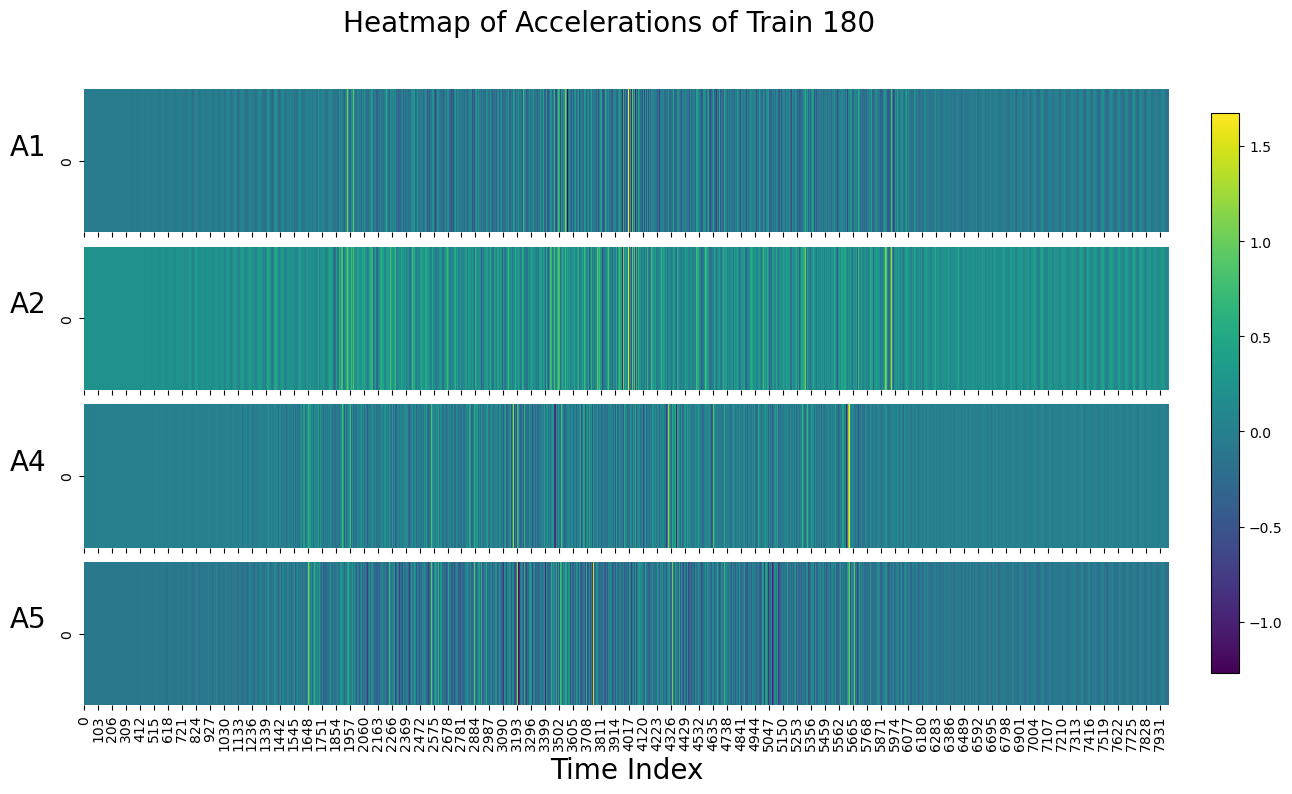

In [71]:
import seaborn as sns
# Create a single figure with multiple subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 8), sharex=True)

# Plot data for each feature
titles = ['A1', 'A2', 'A4', 'A5']
for i, ax in enumerate(axes):
    data = data_testing_X[test_num_visualize][:,i].reshape(1, -1)
    sns_map = sns.heatmap(data, cmap= 'viridis', cbar=False, ax=ax)
    ax.set_ylabel(titles[i], rotation=0, labelpad=10, ha='right',fontsize = 20)  # Horizontal label

# Set xlabel on the last subplot
axes[-1].set_xlabel('Time Index',fontsize=20)

# Create a colorbar axis
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # x, y, width, height (in figure coordinate)

# Normalize the color range based on the data
norm = plt.Normalize(vmin=np.min(data_testing_X[test_num_visualize]), vmax=np.max(data_testing_X[test_num_visualize]))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Create a color bar
fig.colorbar(sm, cax=cbar_ax)

# Adjust layout to make room for colorbar and reduce spacing between plots
plt.subplots_adjust(right=0.9, hspace=0.1)  # hspace controls the vertical gaps between subplots
# set the title of the figure into heatmap of accerlaton data of train 3
plt.suptitle('Heatmap of Accelerations of Train '+ str(train_to_visualize), fontsize=20)

# Save the figure
#plt.savefig('Heatmap of Accelerations of Train 163', dpi=500)

plt.show()


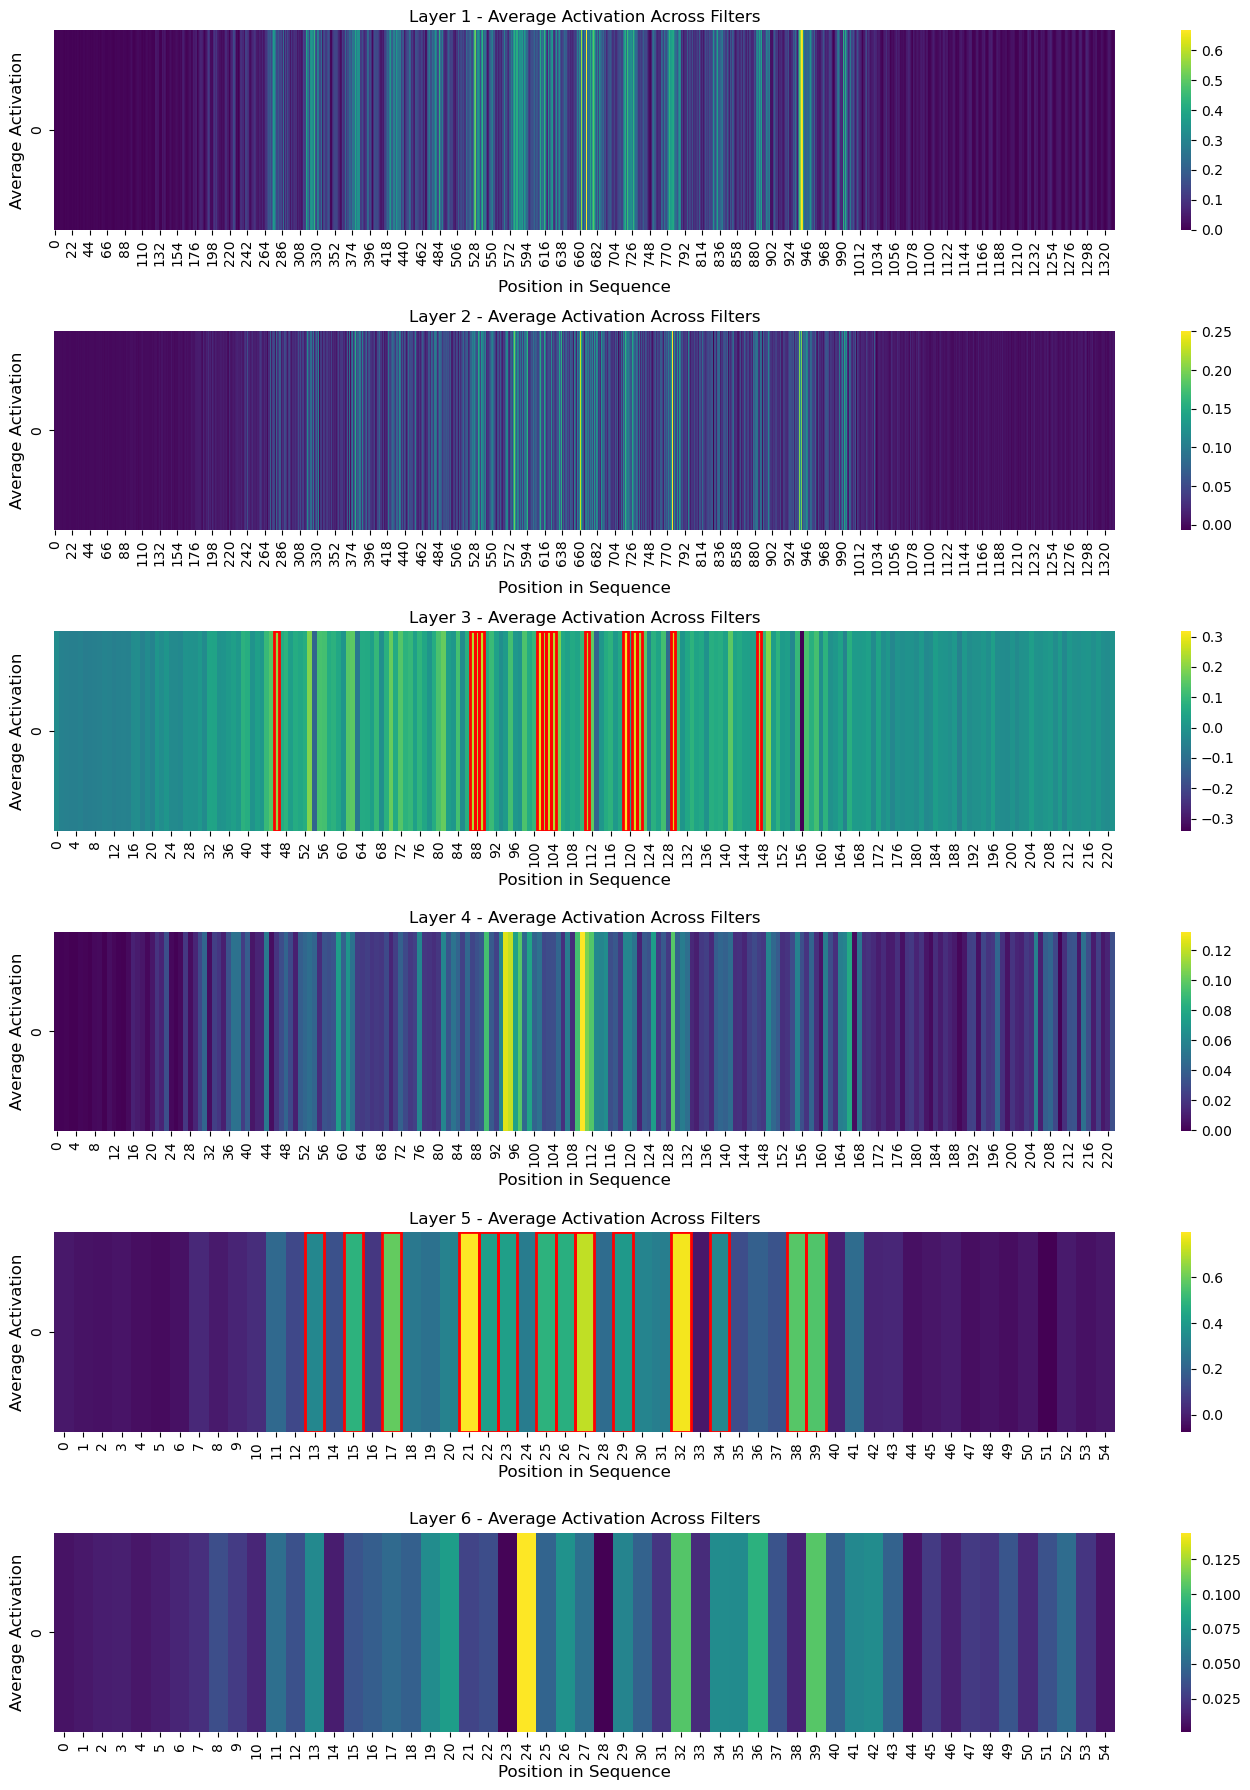

In [72]:
import matplotlib.patches as patches


# Number of layers
num_layers = len(intermediate_outputs)

# Create a single figure with subplots
fig, axes = plt.subplots(nrows=num_layers, figsize=(14, 3 * num_layers))

# Check if there is only one layer to handle indexing appropriately
if num_layers == 1:
    axes = [axes]

# Calculate average activations across filters for each layer and visualize them
for i, layer_activations in enumerate(intermediate_outputs):
    # Calculate the mean across all filters for each feature along the sequence
    avg_activation = np.mean(layer_activations[0], axis=-1)

    # Find indices of the top 4 activations
    top_indices = np.argsort(avg_activation)[-14:]  # This gives us the indices of the top 4 values
    
    # Reshape for heatmap (necessary for single dimensional output)
    avg_activation = avg_activation.reshape(1, -1)
    
    # Create heatmap on the appropriate subplot axis
    ax = sns.heatmap(avg_activation, cmap='viridis', cbar=True, ax=axes[i])
    ax.set_title(f'Layer {i+1} - Average Activation Across Filters', fontsize=12)
    ax.set_ylabel('Average Activation', fontsize=12)
    ax.set_xlabel('Position in Sequence', fontsize=12)

    if i == 2 or i == 4:
            # Adding red borders to the top values
        for top_index in top_indices:
            # Add a rectangle patch with red border to the heatmap
            rect = patches.Rectangle((top_index, 0), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)    

# Adjust layout
plt.tight_layout()

# save the figure to the file

#plt.savefig('Average Activation Across Filters 5-1', dpi=500)

plt.show()


### without speed


In [63]:
# Seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)



# Input layer
inputs = Input(shape=input_shape)


# First Convolutional Block 

x = BatchNormalization()(inputs)
x = Activation('relu')(x)

x = Conv1D(filters=32, kernel_size=9, strides=3, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)

x = MaxPooling1D(pool_size=2)(x)
#x = LayerNormalization()(x)
# Add residual connection
x1 = Conv1D(filters=32, kernel_size=1, strides=3, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(inputs)  # Adjust filters and strides to match x
x1 = MaxPooling1D(pool_size=2)(x1)  # Add same pooling as x
x = Add()([x, x1])



# second Convolutional Block
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(filters=32, kernel_size=5, strides=3, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)

x = MaxPooling1D(pool_size=2)(x)
# layer normalization
#x = LayerNormalization()(x)

# Add residual connection
x2 = Conv1D(filters=32, kernel_size=1, strides=3, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(x1)  # Adjust filters and strides to match x
x2 = MaxPooling1D(pool_size=2)(x2)  # Add same pooling as x
x = Add()([x, x2])



# third Convolutional Block32
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(16, kernel_size=3, strides=2, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)

x = MaxPooling1D(pool_size=2, strides=2, padding='valid')(x)
#x = LayerNormalization()(x)
# Add residual connection
x3 = Conv1D(filters=16, kernel_size=1, strides=2, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(x2)  # Adjust filters and strides to match x
x3 = MaxPooling1D(pool_size=2)(x3)  # Add same pooling as x
x = Add()([x, x3])



# Multi-Head Attention

seq_length = x.shape[1]  # Depends on previous layers' output shape
feature_dim = x.shape[2]  # The number of filters in the last Conv layer


# Assuming 'x' is the input to the attention layer
attention_layer = MultiHeadAttention(num_heads=3, key_dim=feature_dim, kernel_initializer=initializers.GlorotUniform(seed=42))
attention_output, attention_scores = attention_layer(x, x, x, return_attention_scores=True)


# Flattening the output to feed into a dense layer
flat = Flatten()(attention_output)
dense = Dropout(0.25)(flat)




# Final Dense Layers

dense = Dense(32, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=42))(dense)
outputs = Dense(units=16, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=42))(dense)  # Adjust number of units and activation based on your needs





# Create model with two inputs
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
#model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_squared_error'])
#model.compile(optimizer='Adam', loss=weighted_mse_exponential, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_exponential_normal_distribution, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_log_normal_distribution, metrics=['mean_squared_error'])

model.compile(optimizer=optimizer, loss=custom_loss, metrics=['mean_squared_error'])

# Display the model summary to check the architecture
model.summary()

"""# Apply the custom weighting
weighted_predictions = WeightApplication()([dense, scalar_input])

# Final output layer
final_output = Dense(units=32, activation='relu')(weighted_predictions)
final_output = Dense(units=20, activation='relu')(final_output)

# Model definition
model = Model(inputs=[inputs, scalar_input], outputs=final_output)
model.compile(optimizer='Adam', loss=custom_loss, metrics=['mean_squared_error'])

# Model summary
model.summary()"""






Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 8000, 4)]    0           []                               
                                                                                                  
 batch_normalization_18 (BatchN  (None, 8000, 4)     16          ['input_8[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 activation_18 (Activation)     (None, 8000, 4)      0           ['batch_normalization_18[0][0]'] 
                                                                                                  
 conv1d_36 (Conv1D)             (None, 2667, 32)     1184        ['activation_18[0][0]']    

"# Apply the custom weighting\nweighted_predictions = WeightApplication()([dense, scalar_input])\n\n# Final output layer\nfinal_output = Dense(units=32, activation='relu')(weighted_predictions)\nfinal_output = Dense(units=20, activation='relu')(final_output)\n\n# Model definition\nmodel = Model(inputs=[inputs, scalar_input], outputs=final_output)\nmodel.compile(optimizer='Adam', loss=custom_loss, metrics=['mean_squared_error'])\n\n# Model summary\nmodel.summary()"

In [64]:
# nice 140
history = model.fit(x=data_training_X, y=data_training_Y, batch_size=batch_size, epochs=160,
          verbose=1, validation_split=0.1, shuffle=False, callbacks=[early_stopping])

Epoch 1/160
3/3 [==============================] - 1s 103ms/step - loss: 10.3980 - mean_squared_error: 5.1981 - val_loss: 10.1883 - val_mean_squared_error: 5.0921
Epoch 2/160
3/3 [==============================] - 0s 32ms/step - loss: 9.6763 - mean_squared_error: 4.8479 - val_loss: 9.7632 - val_mean_squared_error: 4.8855
Epoch 3/160
3/3 [==============================] - 0s 26ms/step - loss: 8.2775 - mean_squared_error: 4.2815 - val_loss: 8.7578 - val_mean_squared_error: 4.4211
Epoch 4/160
3/3 [==============================] - 0s 23ms/step - loss: 6.8919 - mean_squared_error: 4.1923 - val_loss: 7.9157 - val_mean_squared_error: 4.0516
Epoch 5/160
3/3 [==============================] - 0s 26ms/step - loss: 6.2232 - mean_squared_error: 4.1653 - val_loss: 8.0564 - val_mean_squared_error: 4.0957
Epoch 6/160
3/3 [==============================] - 0s 28ms/step - loss: 5.7267 - mean_squared_error: 3.5495 - val_loss: 8.2808 - val_mean_squared_error: 4.1869
Epoch 7/160
3/3 [====================

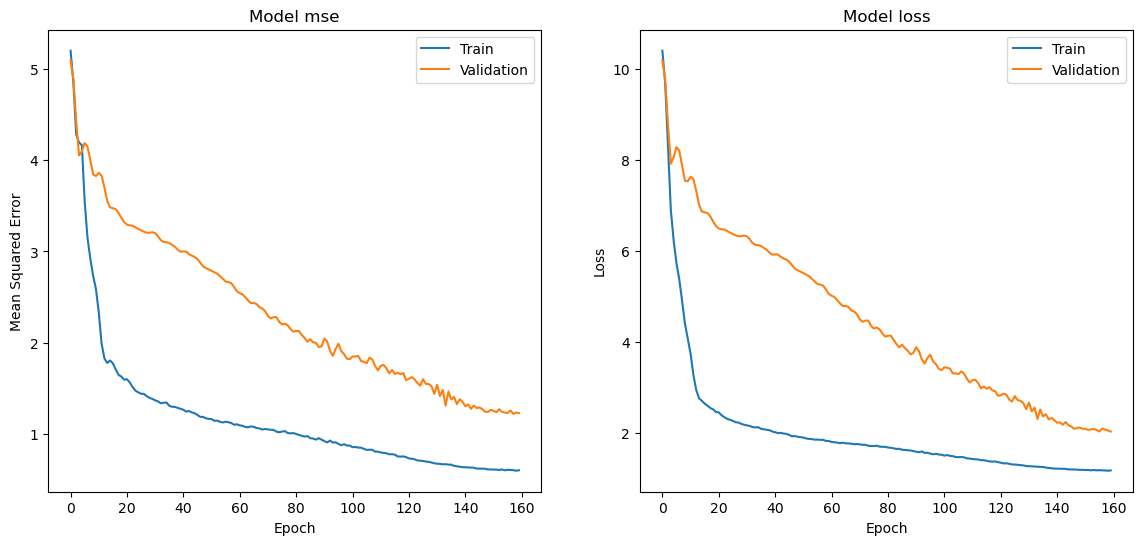

In [65]:
#plot the mse of the training and validation on the left(2,1) and the loss of the training and validation on the right(2,2)
figure = plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_squared_error'][:])
plt.plot(history.history['val_mean_squared_error'][:])
plt.title('Model mse')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'],loc = 'upper right')

# save the figure to the file
#figure.savefig('model_loss3-4.png', dpi=500)
plt.show()

In [66]:
#set a timer to record the time of the prediction]
import time
start = time.time()
# predict the data_testing_X
y_pred = model.predict(data_testing_X)

end = time.time()
print("Time taken to predict the data_testing_X is ", end - start)
# Rounding the predictions
rounded_predictions = round_to_nearest_half(y_pred)


Time taken to predict the data_testing_X is  0.1820690631866455


In [67]:
# calculate the mse of prediction

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# calculate the mse of the prediction
mse = mean_squared_error(data_testing_Y, y_pred)

# calculate the custom loss of the prediction
custom_loss_value = custom_loss(data_testing_Y, y_pred)

# calculate the mean value of custom loss
mean_custom_loss = np.mean(custom_loss_value)

print('The mse of the prediction is ', mse)
print('The mean value of the custom loss is ', mean_custom_loss)

The mse of the prediction is  1.9839673
The mean value of the custom loss is  3.564455


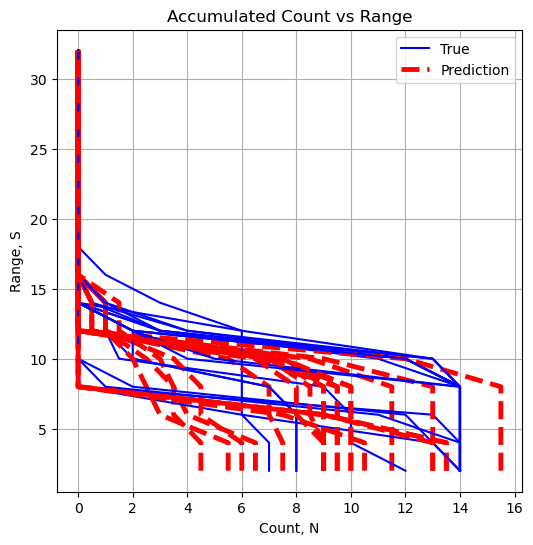

In [68]:
S = list(range(2,34,2))

# Plot all predictions on a same plot
figure = plt.figure(figsize=(6, 6))
for i in range(len(rounded_predictions)):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    #plt.semilogx(Ncum, S, color = 'blue')
    plt.plot(Ncum, S, color = 'blue',linewidth=1.5, label='True')
    #plt.semilogx(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5)
    plt.plot(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5, label='Prediction')
    #plt.title('train number = '+str(test_num[i]))
    # plot the one sigma error bar
    #plt.fill_betweenx(S, pre_Ncum - one_sigma, pre_Ncum + one_sigma, color='red', alpha=0.05)
    plt.xlabel('Count, N')
    plt.ylabel('Range, S')
    #plt.legend()
    plt.grid(True)
    if i == 0:
        plt.legend()
    plt.title('Accumulated Count vs Range')
# save the figure to the file
#figure.savefig('predts 3-4', dpi=500)
# add a test to the plot to show the color of the line

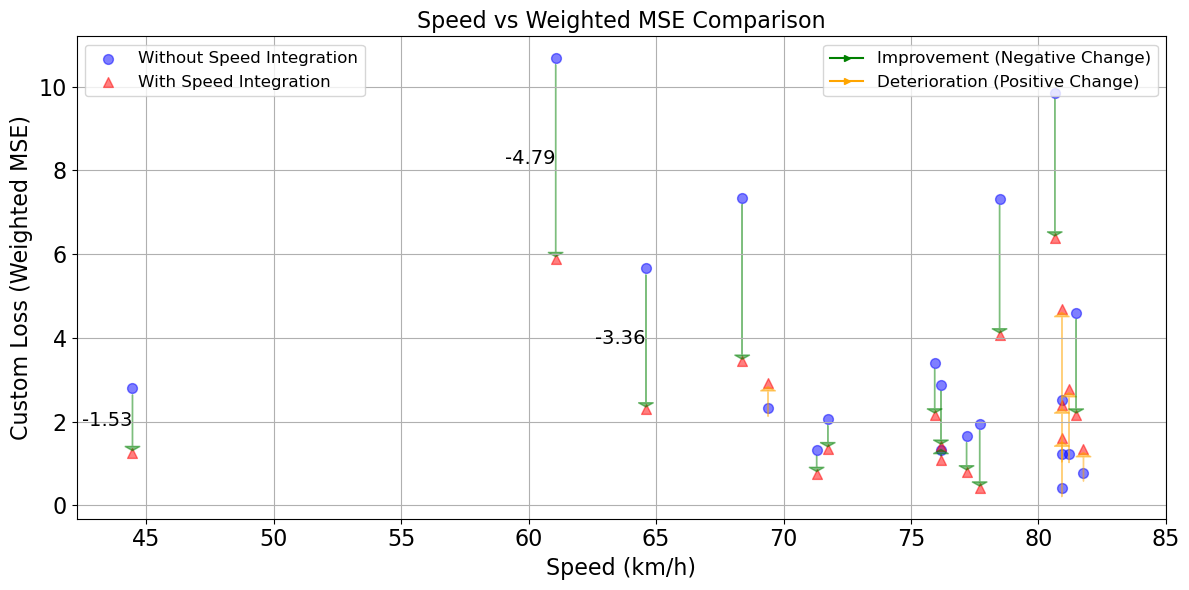

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Denormalize the train speeds
denormalized_data_testing_speed = speed_scaler.inverse_transform(data_testing_speed)

# Setting up the plot
plt.figure(figsize=(12, 6))  # Larger figure size for better readability

# Scatter plots
scatter1 = plt.scatter(denormalized_data_testing_speed, custom_loss_value, 
            label='Without Speed Integration', marker='o', s=50, alpha=0.5, color='blue')
scatter2 = plt.scatter(denormalized_data_testing_speed, CNN_custom_loss_value, 
            label='With Speed Integration', marker='^', s=50, alpha=0.5, color='red')

# Adding arrows and conditional annotations
for i in range(len(denormalized_data_testing_speed)):
    change = CNN_custom_loss_value[i] - custom_loss_value[i]  # Calculate the change
    arrow_color = 'orange' if change > 0 else 'green'

    # Adjust the arrow starting point for visibility
    start_y_position = custom_loss_value[i] - 0.15 if change < 0 else custom_loss_value[i] -0.2
    change_adjusted = change + 0.3 if change < 0 else change +0.01

    # Draw arrow
    plt.arrow(denormalized_data_testing_speed[i], start_y_position, 
              0, change_adjusted, head_width=0.6, head_length=0.1, fc=arrow_color, ec=arrow_color, alpha=0.5)

    # Add text annotation only if the change is negative
    if change < 0:
        if denormalized_data_testing_speed[i] < 65:
            annotation_x_position = denormalized_data_testing_speed[i]
            annotation_y_position = custom_loss_value[i] + change / 2  # Mid-point of the arrow
            plt.text(annotation_x_position, annotation_y_position, f'{change:.2f}', 
                 color='black', ha='right', va='center', fontsize=14)

# Plot aesthetics
plt.xlabel('Speed (km/h)',fontdict={'fontsize': 16})
plt.ylabel('Custom Loss (Weighted MSE)',fontdict={'fontsize': 16})
plt.title('Speed vs Weighted MSE Comparison',fontdict={'fontsize': 16})
plt.xticks(np.arange(45, 90, 5), fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)

# Create custom legend for arrow colors
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='green', markerfacecolor='green', marker='>', label='Improvement (Negative Change)', markersize=5),
                   Line2D([0], [0], color='orange', markerfacecolor='orange', marker='>', label='Deterioration (Positive Change)', markersize=5)]

# Add first legend (scatter plots) to axes
first_legend = plt.legend(handles=[scatter1, scatter2], loc='upper left', fontsize=12)
plt.gca().add_artist(first_legend)

# Add second legend (custom arrows)
plt.legend(handles=legend_elements, loc='upper right',fontsize=12)

plt.tight_layout()  # Adjust layout

# save the figure as svg file
plt.savefig('Figure15.svg', dpi=500, format='svg')


plt.show()


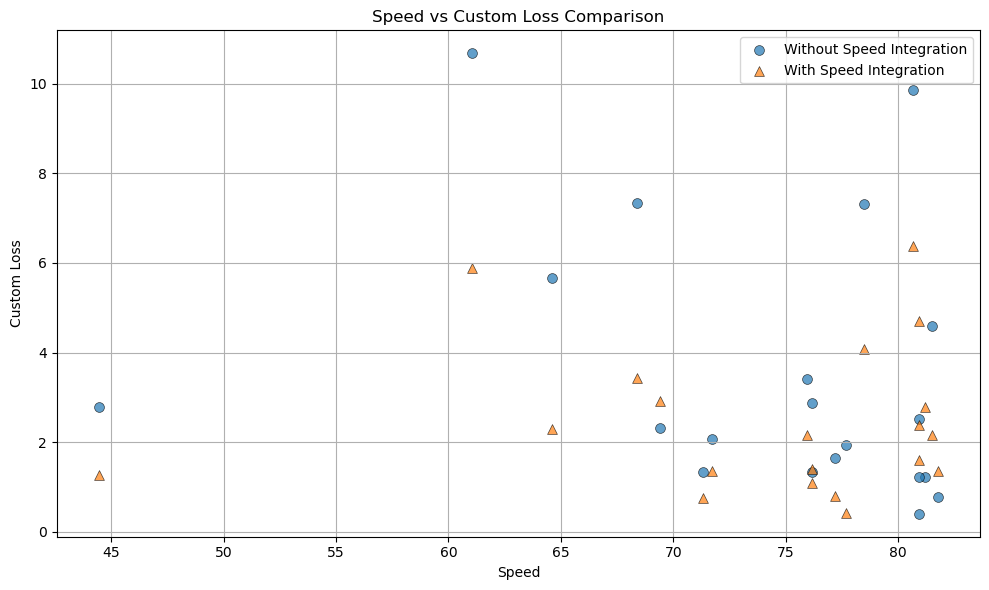

In [72]:
# Denormalize the train speeds
denormailzed_data_testing_speed = speed_scaler.inverse_transform(data_testing_speed)

# Setting up the plot with enhanced features
plt.figure(figsize=(10, 6))  # Increase the figure size for better readability
plt.scatter(denormailzed_data_testing_speed, custom_loss_value, 
            label='Without Speed Integration', marker='o', s=50, alpha=0.7, edgecolors='k', linewidth=0.5)
plt.scatter(denormailzed_data_testing_speed, CNN_custom_loss_value, 
            label='With Speed Integration', marker='^', s=50, alpha=0.7, edgecolors='k', linewidth=0.5)

# Plot aesthetics
plt.xlabel('Speed')
plt.ylabel('Custom Loss')
plt.title('Speed vs Custom Loss Comparison')
plt.grid(True)
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Save the figure to the file
# plt.savefig('Enhanced Speed vs Custom Loss Comparison', dpi=500)

plt.show()


Text(0.09, 0.5, 'Stress Range, S')

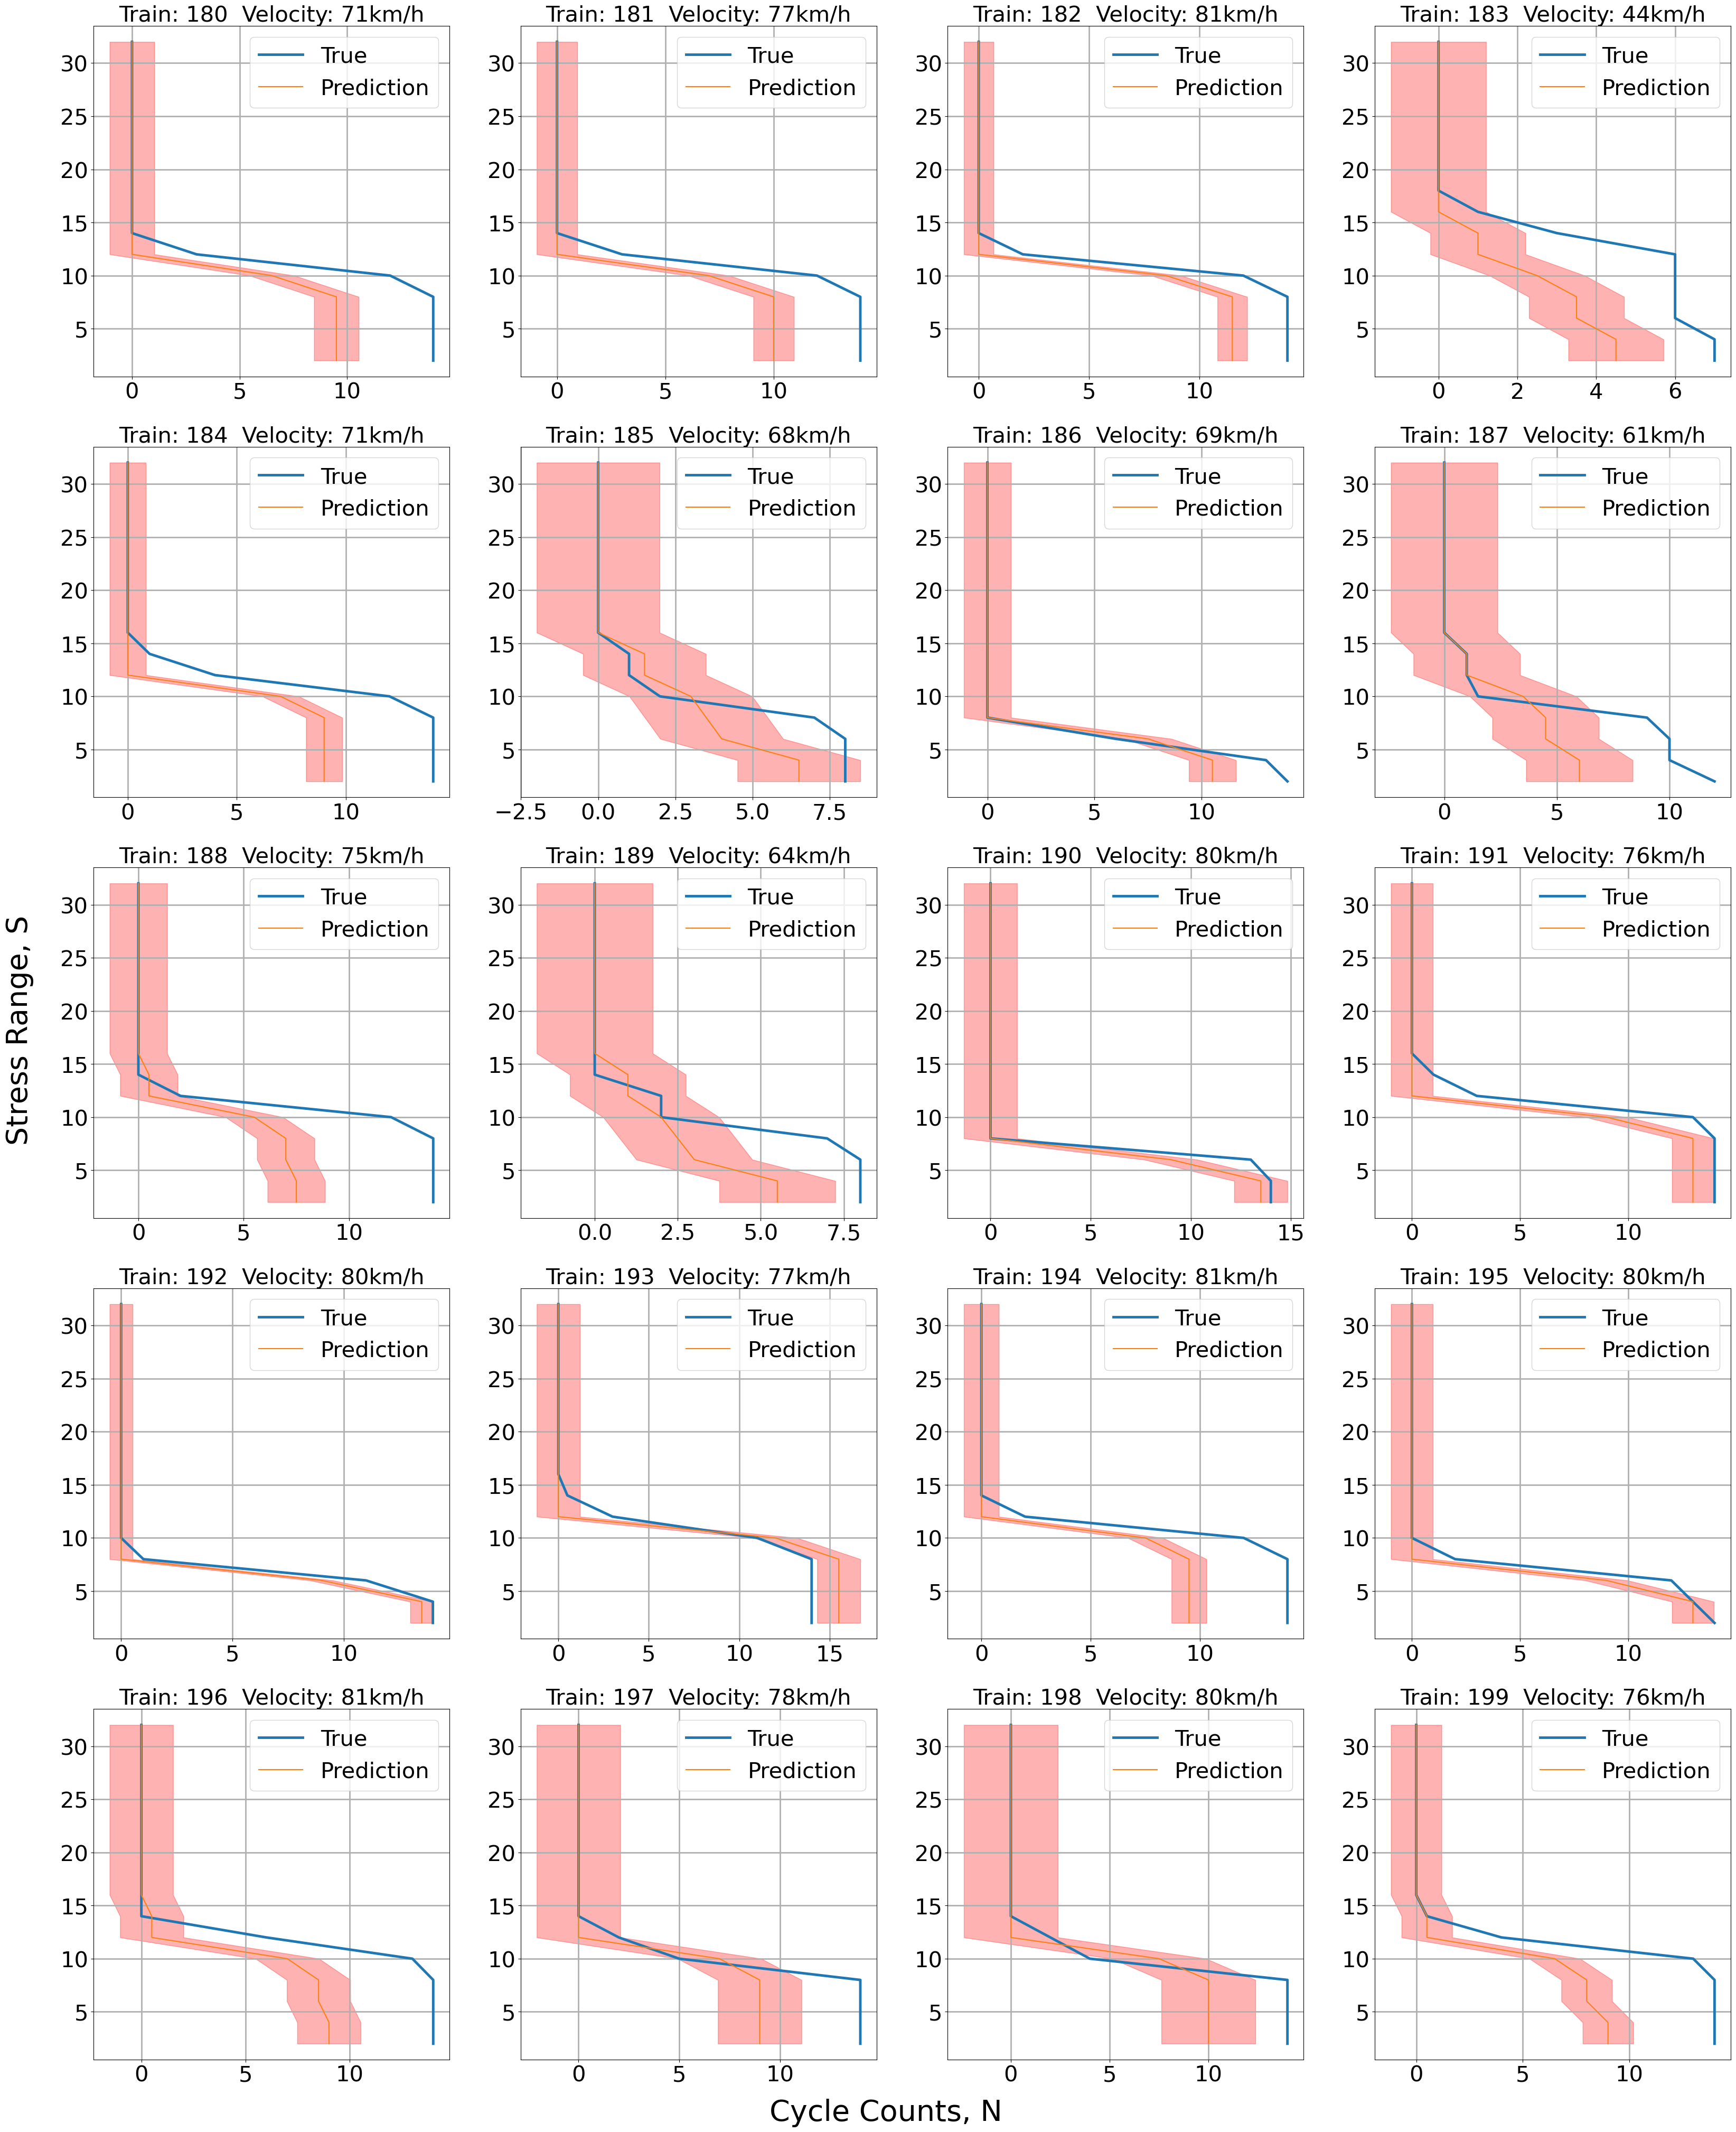

In [71]:

# plot all predictions on a plot with the same color
S = list(range(2,34,2))
figure, axes = plt.subplots(5, 4, figsize=(40, 50))

for i in range(len(rounded_predictions)):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    # calculate the one sigma of the prediction
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    ax = axes[i//4, i%4]
    ax.plot(Ncum, S, label='True',linewidth=3.5)
    # plot the two sigma of the prediction
    ax.fill_betweenx(S, pre_Ncum-1*one_sigma, pre_Ncum+1*one_sigma, color='r', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma, pre_Ncum+1*one_sigma-2*one_sigma, color='y', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum+1*one_sigma, pre_Ncum+2*one_sigma, color='y', alpha=0.3)

    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma-3*one_sigma, pre_Ncum+2*one_sigma+3*one_sigma, color='b', alpha=0.1)

    ax.plot(pre_Ncum, S, label='Prediction')
    # set the title of the plot to show the train number and train velocity
    ax.set_title('Train: '+str(test_num[i])+'  Velocity: '+str(int(denormailzed_data_testing_speed[i][0])) +'km/h',fontsize=30)
    #ax.set_xlabel('Count, N')
    #ax.set_ylabel('Range, S')
    # make the font size of label and title bigger
    ax.tick_params(axis='both', which='major', labelsize=30)
    # make the font size of x and y notations bigger
    ax.title.set_size(30)
    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)

    # make the legend bigger
    ax.legend(prop={'size': 30})

    ax.grid(True, linewidth=2)
# Set common labels
figure.text(0.5, 0.09, 'Cycle Counts, N', ha='center', va='center', fontsize=40)
figure.text(0.09, 0.5, 'Stress Range, S', ha='center', va='center', rotation='vertical', fontsize=40)

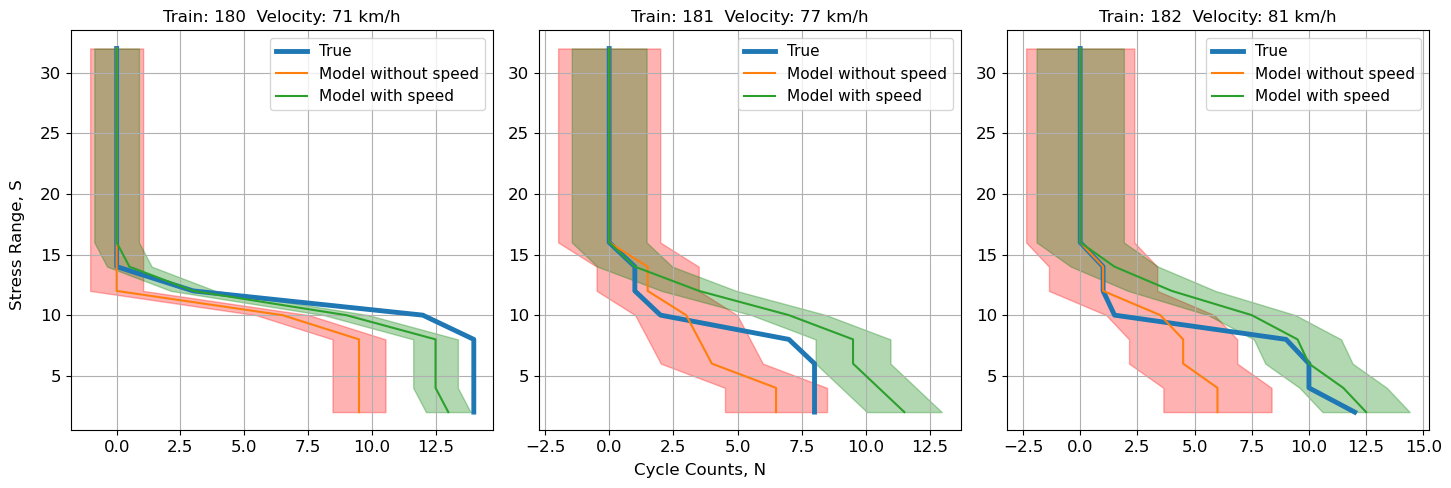

In [70]:
S = list(range(2, 34, 2))
selected_indices = [0, 5, 7]  # Correspond to first, third, fourth in low_speed
figure, axes = plt.subplots(1, 3, figsize=(15, 5))

for plot_idx, data_idx in enumerate(selected_indices):
    pre_N = rounded_predictions[data_idx]
    N = data_testing_Y[data_idx]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    CNN_pre_N = CNN_rounded_predictions[data_idx]
    CNN_pre_Ncum = CNN_pre_N.sum() - np.cumsum(CNN_pre_N)
    CNN_one_sigma = np.sqrt(np.mean((CNN_pre_N - N)**2))

    ax = axes[plot_idx]
    ax.plot(Ncum, S, label='True', linewidth=3.5)
    ax.fill_betweenx(S, pre_Ncum - one_sigma, pre_Ncum + one_sigma, color='r', alpha=0.3)
    ax.fill_betweenx(S, CNN_pre_Ncum - CNN_one_sigma, CNN_pre_Ncum + CNN_one_sigma, color='g', alpha=0.3)
    ax.plot(pre_Ncum, S, label='Model without speed')
    ax.plot(CNN_pre_Ncum, S, label='Model with speed')

    ax.set_title(f'Train: {test_num[plot_idx]}  Velocity: {int(denormailzed_data_testing_speed[plot_idx][0])} km/h', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(prop={'size': 11})
    ax.grid(True)

figure.text(0.5, 0.04, 'Cycle Counts, N', ha='center', fontsize=12)
figure.text(0.04, 0.5, 'Stress Range, S', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
# save the figure as the svg file
#figure.savefig('Figure16.svg', dpi=800, format='svg')

plt.show()


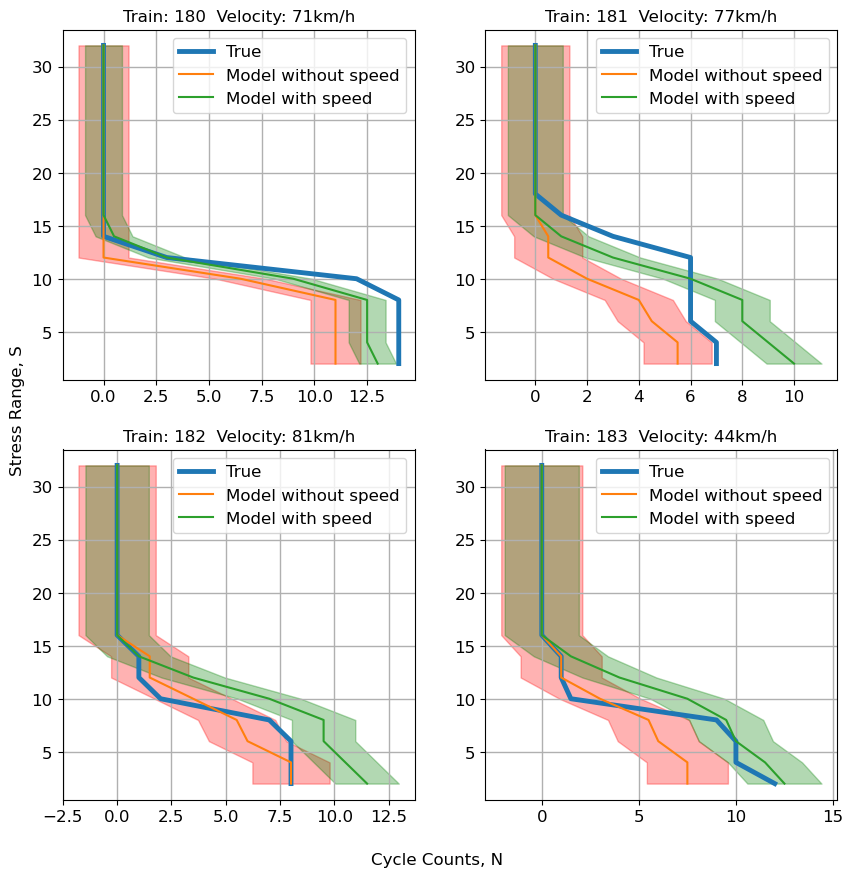

In [82]:

# plot all predictions on a plot with the same color
S = list(range(2,34,2))
figure, axes = plt.subplots(2, 2, figsize=(10, 10))

low_speed = [0,3,5,7]

for idx, i in enumerate(low_speed):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    # calculate the one sigma of the prediction
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    CNN_pre_N = CNN_rounded_predictions[i]
    CNN_pre_Ncum = CNN_pre_N.sum() - np.cumsum(CNN_pre_N)
    # calculate the one sigma of the prediction
    CNN_one_sigma = np.sqrt(np.mean((CNN_pre_N - N)**2))

    # Fixing the subplot indexing
    ax = axes[idx // 2, idx % 2]  # Ensure using idx here to calculate subplot positions
    ax.plot(Ncum, S, label='True', linewidth=3.5)
    ax.fill_betweenx(S, pre_Ncum-1*one_sigma, pre_Ncum+1*one_sigma, color='r', alpha=0.3)
    ax.fill_betweenx(S, CNN_pre_Ncum-1*CNN_one_sigma, CNN_pre_Ncum+1*CNN_one_sigma, color='g', alpha=0.3)

    ax.plot(pre_Ncum, S, label='Model without speed')
    ax.plot(CNN_pre_Ncum, S, label='Model with speed')
    ax.set_title(f'Train: {test_num[idx]}  Velocity: {int(denormailzed_data_testing_speed[idx][0])}km/h', fontsize=12)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(prop={'size': 12})
    ax.grid(True, linewidth=1.0)

# Set common labels if needed
figure.text(0.5, 0.05, 'Cycle Counts, N', ha='center', va='center', fontsize=12)
figure.text(0.08, 0.5, 'Stress Range, S', ha='center', va='center', rotation='vertical', fontsize=12)

plt.show()